In [100]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.optimize import brentq
from scipy.integrate import quad
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize
from numpy.polynomial.laguerre import laggauss
from joblib import Parallel, delayed
from numpy.linalg import lstsq

!pip install arch
import arch
from arch import arch_model
from dateutil import parser
from dateutil.tz import tzutc

sns.set_style('darkgrid')

## **Option Terminology**
**Premium**: The price paid by the option buyer to the option seller for obtaining the right. It represents the cost of the option.

**Strike Price**: The predetermined price at which the underlying asset can be bought or sold.

**Expiration Date**: The date when the option contract expires. After this date, the option is no longer valid.

**Time to Expiration**: The amount of time in years to contract expiration date.

**In-the-Money (ITM)**: For a call option, when the market price is above the strike price. For a put option, when the market price is below the strike price.

**Out-of-the-Money (OTM)**: For a call option, when the market price is below the strike price. For a put option, when the market price is above the strike price.

**At-the-Money (ATM)**: When the market price is equal to the strike price.
Spot Price/Asset Price: Price of the underlying asset.

# **European Options**

A **(European) call option** is a contract between two parties, a buyer and a seller, that gives the buyer the right, but not the obligation, **to buy an underlying asset** from the seller for a predetermined price
$K$, called the strike price at a future point of time.

A *(European) put option* is a contract between two parties, a buyer and a seller, that gives the buyer the right, but not the obligation, **to sell an underlying asset** to the seller for a predetermined price $K$, called the strike price at a future point of time.



# **Fair Market Price of an Option Contract**
Let $S_t$ denote the value of a stock at a time $t$. Consider a call option on the stock with strike price $K$ that expires at time $t$. The value of the call option at the expiration time $t$ is $$\max(S_t - K, 0)$$

The **fair market value** of the call option at time $0$ is the expected value of $\max(S_t - K, 0)$, discounted to time $0$, i.e.,
$$C_0 = e^{-rt}\mathbb{E}[\max(S_t - K, 0)]$$

Similarly, consider a put option on the stock with strike price $K$ that expires at time $t$. The value of the put option at the expiration time $t$ is
$$\max(K - S_t, 0)$$

The fair market value of the put option at time $0$ is the expected value of
$$\max(K - S_t, 0)$$ discounted to time $0$, i.e., $$P_0 = e^{-rt}\mathbb{E}[\max(K - S_t, 0)]$$

## **Put-Call Parity**
The prices of put and call options respect the put-call parity formula, i.e.
$$P_0 - C_0 = Ke^{-rt} - S_0$$

## **Option pricing via Monte-Carlo Methods**
It we assume a model of stock prices $S_t$, then we can use Monte-Carlo methods to estimate the values $C_0 = e^{-rt}\mathbb{E}[\max(S_t - K, 0)]$
and $P_0 = e^{-rt}\mathbb{E}[\max(K - S_t, 0)]$


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


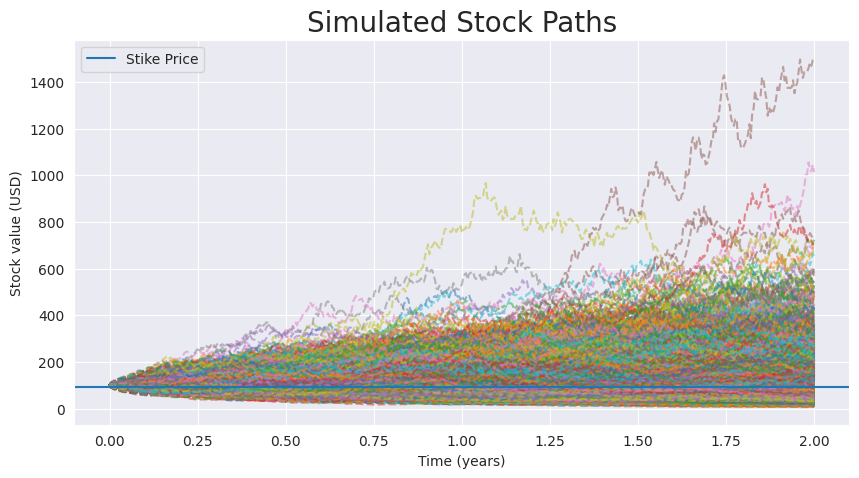

Estimated call value (discounted to time 0): $28.94
Estimated put value (discounted to time 0): $18.18
P - C: $-10.76
K*e^0.07 - S: $-11.42


In [101]:
## Randomly generated stock paths as Geometric Brownian Motions

def GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps):
    """Simulates stock paths as geometric Brownian Motions
    Inputs:
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in each simulated path, each step interval has length t/n_steps

    Return (np.array): Array of stock paths
    """

    dt = t/n_steps
    noise = np.random.normal(loc = 0, scale = 1, size = (n_sims, n_steps))
    log_returns = (mu+r-sigma**2*(0.5))*dt + sigma*np.sqrt(dt)*noise;
    exponent = np.cumsum(log_returns, axis = 1)
    paths = S0*np.exp(exponent)
    paths_with_start = np.insert(paths, 0, S0, axis = 1)

    return paths_with_start

S0 = 100

sigma = .45

t = 2

r = .035

mu = 0 #mu =0 represents the risk-free stock-path model

n_sims = 10000

n_steps = 500


time = np.linspace(0, t, n_steps + 1)

stock_paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)


K = 95

plt.figure(figsize = (10,5))
for path in stock_paths:

    plt.plot(time, path, alpha = .5, ls = '--')




plt.axhline(K, label = 'Stike Price')



plt.xlabel('Time (years)')
plt.ylabel('Stock value (USD)')
plt.title('Simulated Stock Paths', size = 20)

plt.legend()
plt.show()


path_endpoints = stock_paths[:,-1]

call_values = np.maximum(path_endpoints-K, 0)

put_values = np.maximum(K - path_endpoints, 0)

call_values_discounted = np.exp(-r*t)*call_values

put_values_discounted = np.exp(-r*t)*put_values

call_value_estimate = np.mean(call_values_discounted)

put_value_estimate = np.mean(put_values_discounted)

print(f'Estimated call value (discounted to time 0): ${call_value_estimate:.2f}')

print(f'Estimated put value (discounted to time 0): ${put_value_estimate:.2f}')

print(f'P - C: ${put_value_estimate - call_value_estimate:.2f}')

print(f'K*e^{r*t} - S: ${K*np.exp(-r*t) - S0:.2f}')


# **Black-Scholes Equation for Call and Put Options**
Let $t > 0$ and assume the distribution of stock prices $S_t$ from time $0$ to time $t$ is the risk-free Geometric Brownian Motion model:
$$S_t = S_0e^{\big(r - \frac{\sigma^2}{2}\big)t + \sigma \sqrt{t}\mathcal{N}(0, 1)},$$
where:

$S_0$ is the stock price at time $0$;

$\sigma$ the is yearly standard deviation of log-returns;

$r$ is the risk-free interest rate;

$\mathcal{N}(0, 1)$ is the standard normal distribution;

Let $\varphi$ and $\Phi$ denote the probability density function (PDF) and cumulative distribution function (CDF) of the standard normal distribution respectively:

$$\varphi(x) = \frac{e^{-x^2}}{2} \text{ and } \Phi(y) = \mathbb{P}\big(\mathcal{N}(0, 1) \le y\big) = \int_{-\infty}^{y} \varphi(x) \,dx$$

Let $K > 0$ be a strike price. Denote by $C_t = \max(S_t - K, 0)$ and $P_t = \max(K - S_t, 0)$ the distriubtion of respective values of a call and a put option at expiration time $t$. Let
$$C_0 = e^{-rt}\mathbb{E}[\max(S_t - K, 0)] \text{ and } P_0 = e^{-rt}\mathbb{E}[\max(K - S_t, 0)]$$
be the discounted to time $0$ expected values of $C_t$ and $P_t$ respectively. Then
$$C_0 = S_0 \Phi(d_1) - Ke^{-rt}\Phi(d_2) \text{ and } P_0 = -S_0 \Phi(-d_1) + Ke^{-rt}\Phi(-d_2),$$
where
$$d_1 = \frac{\ln\big(S_0/K) + (r + σ^2/2)t}{σ \sqrt{t}} \text{ and } d_2 = d_1 - σ \sqrt{t}$$
Note that the probabilities that the options expire in the money are the following:
$$\mathbb{P}[C_t > 0 ] = \Phi(d_2) \text{ and } \mathbb{P}[P_t > 0] = \Phi(-d_2)$$
Moreover, they satisfy
$$S_0 \varphi(d_1) = e^{-rt}\phi(d_2)$$

# **Delta**
The **delta** of an option is the rate of change of the Black-Scholes price of the option with respect to the price of the underlying stock price $S_0$:
$$Δ_{C_0} := \frac{\partial C_0}{\partial S_0} = \Phi(d_1), Δ_{P_0} := \frac{\partial P_0}{\partial S_0} = -1 + \Phi(d_1)$$

# **Vega**
The **vega of an option is the rate of change of the Black-Scholes price of the option with respect to volatility $\sigma$:
$$\nu_{C_0} = \nu_{P_0} := \frac{\partial C_0}{\partial \sigma} = S_0 \varphi(d_1)\sqrt{t} = e^{-rt}K\varphi(d_2)\sqrt{t}$$

# **Remark:**

The above formulas assume that option prices can be determined using a risk-neutral valuation framework. This assumption can be justified under the following assumptions:

* A trader can continuously buy and sell fractional shares of the stock to construct a dynamic hedging portfolio that replicates the option payoff.
* There are no transaction costs or bid-ask spreads.

Moreover, Black-Scholes assumes the following about a stock-path:

* a stock path has log-normal returns and log-returns over a period of time are independent of log-returns over a previous time;

* Log-returns are normally distributed;

* Volatility is constant;

In [102]:
##Black-Scholes Functions
def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes value of call option (float)
    '''

    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))

    d2 = d1 - sigma*np.sqrt(t)


    call_value = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)


    return call_value



def bs_put(S0, K, sigma, t, r):
    '''
    Black-Scholes Put Option formula

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes value of put option (float)
    '''

    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))

    d2 = d1 - sigma*np.sqrt(t)


    put_value = -S0*norm.cdf(-d1) + K*np.exp(-r*t)*norm.cdf(-d2)


    return put_value


def bs_call_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Call Option

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes rate of change of call option with respect to S_0

    '''


    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))


    return norm.cdf(d1)



def bs_put_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Put Option

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes rate of change of put option with respect to S_0

    '''
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))


    return -1 + norm.cdf(d1)


def bs_vega(S0, K, sigma, t, r):
    '''Black-Scholes vega of Call & Put Options

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes rate of change of call & put option with respect to sigma

    '''

    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))


    return S0*norm.pdf(d1)*np.sqrt(t)




## **Hedging**
The process of hedging an option, from a market-makers point of view, is the process of selling option contracts, and then buying and selling the underlying stock over the interval of time to expiration, and is done so to neutralize the risk of big losses and to protect profits obtained from the premium gathered from selling options.

[*********************100%***********************]  8 of 8 completed


Running AAPL...
Running AMZN...
Running GOOGL...
Running META...
Running MSFT...
Running NVDA...
Running TSLA...
Running SPY...
          mean    std  count  Sharpe
Ticker                              
AAPL    4.3166 1.1847     24  3.6436
AMZN    3.6280 1.4570     24  2.4901
GOOGL   3.2873 1.2093     24  2.7184
META    8.3868 4.6165     24  1.8167
MSFT    8.5649 3.0921     24  2.7700
NVDA    1.5252 1.1567     24  1.3186
SPY    12.1199 3.4460     24  3.5171
TSLA    6.0099 4.4565     24  1.3486


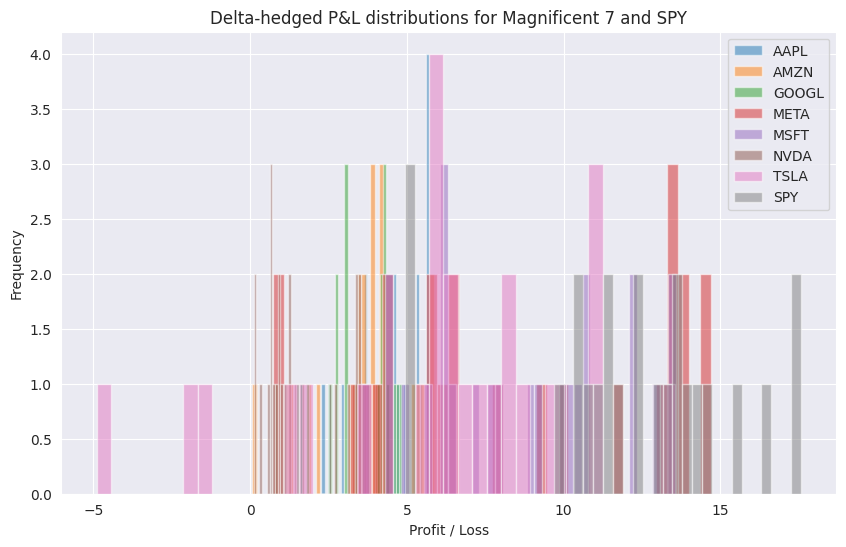

In [103]:
tickers = ["AAPL", "AMZN", "GOOGL", "META", "MSFT", "NVDA", "TSLA", "SPY"]
r = 0.035
window = 252

data = yf.download(tickers, start="2022-01-01", end="2025-01-01", auto_adjust=True)
data_close = data["Close"]
returns = np.log(data_close / data_close.shift(1))
realized_vol = returns.rolling(window).std() * np.sqrt(252)

def hedge_on_historical_path(prices, K, sigma_real, sigma_model, r):
    n_steps = len(prices) - 1
    T = 1
    times = np.linspace(0, T, n_steps + 1)
    S = prices.values
    deltas = np.zeros(n_steps + 1)
    for j in range(n_steps + 1):
        tau = T - times[j]
        if tau == 0:
            tau = 1e-8
        deltas[j] = bs_call_delta(S[j], K, sigma_model, tau, r)
    stock_changes = S[1:] - S[:-1]
    stock_profits = deltas[:-1] * stock_changes
    discount_factors = np.exp(-r * times[1:])
    total_stock_profits = np.sum(stock_profits * discount_factors)
    call_payout_discounted = max(S[-1] - K, 0) * np.exp(-r * T)
    premium = bs_call(S[0], K, sigma_model, T, r)
    pnl = premium + total_stock_profits - call_payout_discounted
    return pnl

results = []
for ticker in tickers:
    print(f"Running {ticker}...")
    series = data_close[ticker].dropna()
    realized_vol_series = realized_vol[ticker]
    for i in range(252, len(series) - 1, 21):
        sigma_real = realized_vol_series.iloc[i]
        if np.isnan(sigma_real) or sigma_real <= 0:
            continue
        window_prices = series.iloc[i - 252 : i + 1]
        sigma_model = sigma_real + 0.01 #can change the 0.01, this just says how much more the price of the option is in the market
        K = window_prices.iloc[0]
        pnl = hedge_on_historical_path(window_prices, K, sigma_real, sigma_model, r)
        results.append({
            "Ticker": ticker,
            "StartDate": window_prices.index[0],
            "EndDate": window_prices.index[-1],
            "SigmaReal": sigma_real,
            "SigmaModel": sigma_model,
            "PnL": pnl
        })

df_results = pd.DataFrame(results)
summary = df_results.groupby("Ticker")["PnL"].agg(["mean", "std", "count"])
summary["Sharpe"] = summary["mean"] / summary["std"]
print(summary)

plt.figure(figsize=(10,6))
for ticker in tickers:
    subset = df_results[df_results["Ticker"] == ticker]
    plt.hist(subset["PnL"], bins=40, alpha=0.5, label=ticker)
plt.legend()
plt.title("Delta-hedged P&L distributions for Magnificent 7 and SPY")
plt.xlabel("Profit / Loss")
plt.ylabel("Frequency")
plt.show()

In [104]:
##Implied volatility functions
def implied_volatility_call(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    def objective(sigma):
        return bs_call(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan

def implied_volatility_put(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    def objective(sigma):
        return bs_put(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan



##Functions for option data obtained through y-finance
def find_tte_yf_options(expiration_date,last_trade_date):
    tte = (datetime.datetime.strptime(expiration_date+'-21-30', "%Y-%m-%d-%H-%M").replace(tzinfo=tzutc()) -\
last_trade_date).total_seconds()/(60*60*24*365)

    return tte


def yf_find_approx_spot(stock_data, last_trade_date):
    # Round timestamp to the minute (zero out seconds)
    ts = last_trade_date.replace(second=0)

    try:
        return stock_data.loc[ts].iloc[0]
    except KeyError:
        return float('nan')

## **The Heston Model**
The Heston model is a stochastic volatility model whose corresponding formula for option contracts naturally simulates the phenomena of v**olatility smiles** in market data. The Heston model for this reason is likely a more robust model for designing hedging stratigies for two reasons. The first, the Heston model naturally incoroporates autoregressive features of log-returns observed in markets. The second is that the Heston model can simulate option market prices and therefore is more likely to be a better method of simulating a portfolio's distribution of market value throughout the duration of managing an option portfolio.

## **The $n$-step discrete Heston Model:**
Let $0 = t_0 < t_1 < \ldots < t_n = t$, then the $n$-step discrete Heston model assumes for each $1 \le i \le n$, the variance of the log-returns at time $t_i$ is modeled as
$$\nu_{t_i} = \max(\nu_{t-1}, 0) + \kappa(\theta - \max(\nu_{t_{i-1}}, 0))(t_i - t_{i - 1}) + \xi(\sqrt{\max(\nu_{t-1}, 0)(t_i - t_{i - 1})}\mathcal{N}^{\nu}(0, 1)$$
and the distribution of stock paths from time $t_{i - 1}$ to $t_i$ is modeled as
$$S_{t_i} = S_{t_{i - 1}}e^{\mu + r - \max(\nu_{t_{i - 1}}, 0)(t_{i} - t_{i - 1})/2 + \xi(\sqrt{\max(\nu_{t-1}, 0)(t_i - t_{i - 1})}\mathcal{N}^{S}(0, 1)}$$
where
* $S_0$ is the initial stock price;

* $S_t$ is the stock price at time $t$;

* $\nu_0$ is the variance of the stock at time $0$;

* $\nu_t$ is the variance of the stock at time $t$;

* $\mu$ is the excess drift of the log-returns of the stock;

* $r$ is the risk-free interest rate;

* $\kappa$ is the mean-reversion rate of the variance process;

* $\theta$ is the long-run variance level of the variance process;

* $\xi$ is the volatility of volatility;

* $\mathcal{N}^{\nu}(0, 1)$ and $\mathcal{N}^S(0, 1)$ are standard normal distributions with correlation $\rho$;


# **Remark 1:**
The general definition of the Heston Model describes the variance and stock paths as being modeled as intertwined solutions to a system of stochastic Partial Differential Equations. The limiting distribution of variances and stock paths of the discrete models as the number of steps tends to $\infty$ is the continuous model described by the system of stochastic partial differential equations.

# **Remark 2:**
The Heston model is a generalization of the Black-Scholes/Geometric Brownian Motion Model. The two models agree if:


* $\nu = 0$;
* $\kappa = 0$;  
* $\xi = 0$;

# **Remark 3:**

Some realistic ranges of the parameters $\kappa, \xi, \rho$ for a Heston model are the following:


* $1 \le \kappa \le 5$;
* $0.2 \le \xi \le 1$;
* $-0.9 \le \rho \le -0.2$;




In [105]:
## Heston functions using the characteristic function of the Heston model derived by Heston.

def heston_call(S0, K, v0, r, t, kappa, theta, xi, rho):

    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    return call_price


def heston_call_delta(S0, K, v0, r, t, kappa, theta, xi, rho):
    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    return P1

def heston_put(S0, K, v0, r, t, kappa, theta, xi, rho):
    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]

    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    put_price = call_price - S0 + K * np.exp(-r * t) #a bit of a cheat, used put-call parity

    return put_price


def heston_put_delta(S0, K, v0, r, t, kappa, theta, xi, rho):
    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    return P2



def heston_option(S0, K, v0, r, t, kappa, theta, xi, rho, option_type):
    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    put_price = call_price - S0 + K * np.exp(-r * t)

    if option_type == 'call':
        return call_price

    if option_type == 'put':
        return put_price

In order to estimate $\kappa, \xi,$ and $\rho$, we do a basic linear regression

In [106]:
from sklearn.linear_model import LinearRegression

def estimate_heston_params(stock_data, ticker, window=252):
    log_returns = np.log(stock_data["Close"][ticker]).diff().dropna()
    realized_var = (log_returns.rolling(window=21).std() ** 2 * 252).dropna()
    theta = realized_var.mean()
    v_t = realized_var[:-1].values.reshape(-1, 1)
    v_next = realized_var[1:].values.reshape(-1, 1)
    dv = v_next - v_t
    X = theta - v_t
    reg = LinearRegression().fit(X, dv)
    kappa = max(reg.coef_[0][0], 0.1)

    residuals = dv - reg.predict(X)
    xi = np.sqrt(np.var(residuals) / np.mean(v_t)) * np.sqrt(252)
    xi = np.clip(xi, 0.05, 1.0)

    rho = np.corrcoef(log_returns[-len(residuals):], residuals.flatten())[0, 1]
    rho = np.clip(rho, -0.9, -0.1)

    return {
        "Ticker": ticker,
        "kappa": float(kappa),
        "theta": float(theta),
        "xi": float(xi),
        "rho": float(rho)
    }

We use Monte-Carlo simulation to simulate delta-hedging under the Heston model.

In [107]:
def heston_mc_hedging_tickers_fitted(stock_data, tickers,
                                     r=0.035, mu=0.04,
                                     t=1.0, n_steps=252, n_sims=3000):
    """
    Monte Carlo Heston-model delta-hedging simulation
    using *fitted parameters per ticker*.
    """

    results = []
    dt = t / n_steps
    times = np.linspace(0, t, n_steps + 1)

    for ticker in tickers:
        print(f"\n🔹 Fitting Heston parameters for {ticker}...")
        params = estimate_heston_params(stock_data, ticker)
        kappa, theta, xi, rho = params["kappa"], params["theta"], params["xi"], params["rho"]

        print(f"  κ={kappa:.3f}, θ={theta:.4f}, ξ={xi:.3f}, ρ={rho:.3f}")

        S0 = stock_data["Close"][ticker].iloc[-1]
        sigma_hist = np.log(stock_data["Close"][ticker].pct_change() + 1).rolling(21).std().iloc[-1] * np.sqrt(252)
        sigma0 = sigma_hist if not np.isnan(sigma_hist) else np.sqrt(theta)
        v0 = sigma0 ** 2
        K = S0

        noise1 = np.random.normal(size=(n_sims, n_steps))
        Y = np.random.normal(size=(n_sims, n_steps))
        noise2 = rho * noise1 + np.sqrt(1 - rho ** 2) * Y

        vols = np.zeros((n_sims, n_steps))
        vols[:, 0] = v0
        for i in range(1, n_steps):
            vols[:, i] = vols[:, i-1] + kappa * (theta - vols[:, i-1]) * dt \
                         + xi * np.sqrt(np.maximum(vols[:, i-1], 0)) * np.sqrt(dt) * noise1[:, i-1]
            vols[:, i] = np.maximum(vols[:, i], 0)

        log_returns = (mu + r - 0.5 * vols) * dt + np.sqrt(np.maximum(vols, 0)) * np.sqrt(dt) * noise2
        exponent = np.cumsum(log_returns, axis=1)
        paths = S0 * np.exp(exponent)
        paths = np.insert(paths, 0, S0, axis=1)

        path_endpoints = paths[:, -1]
        call_payouts_discounted = np.maximum(path_endpoints - K, 0) * np.exp(-r * t)

        deltas = bs_call_delta(paths[:, 0:n_steps], K, sigma0, (t - times)[0:n_steps], r)

        stock_profits_discounted = (paths[:, 1:n_steps + 1] - paths[:, 0:n_steps] * np.exp(r * dt)) \
                                   * deltas * np.exp(-r * times[1:n_steps + 1])
        total_stock_profits = np.sum(stock_profits_discounted, axis=1)

        call_profits_hedged = call_payouts_discounted - total_stock_profits

        results.append({
            "Ticker": ticker,
            "kappa": kappa,
            "theta": theta,
            "xi": xi,
            "rho": rho,
            "MeanPnL": np.mean(call_profits_hedged),
            "StdPnL": np.std(call_profits_hedged),
            "ProbLoss": np.mean(call_profits_hedged < 0),
            "MinPnL": np.min(call_profits_hedged),
            "MaxPnL": np.max(call_profits_hedged)
        })

    return pd.DataFrame(results)

tickers = ["AAPL","AMZN","GOOGL","META","MSFT","NVDA","TSLA","SPY"]

df_mc_fitted = heston_mc_hedging_tickers_fitted(
    stock_data=data,
    tickers=tickers,
    r=0.035,
    mu=0.04,
    t=1.0,
    n_steps=252,
    n_sims=3000
)

print(df_mc_fitted)



🔹 Fitting Heston parameters for AAPL...
  κ=0.100, θ=0.0741, ξ=0.581, ρ=-0.100

🔹 Fitting Heston parameters for AMZN...
  κ=0.100, θ=0.1490, ξ=1.000, ρ=-0.100

🔹 Fitting Heston parameters for GOOGL...
  κ=0.100, θ=0.1090, ξ=0.791, ρ=-0.100

🔹 Fitting Heston parameters for META...
  κ=0.100, θ=0.2492, ξ=1.000, ρ=-0.150

🔹 Fitting Heston parameters for MSFT...
  κ=0.100, θ=0.0773, ξ=0.585, ρ=-0.100

🔹 Fitting Heston parameters for NVDA...
  κ=0.100, θ=0.3007, ξ=1.000, ρ=-0.100

🔹 Fitting Heston parameters for TSLA...
  κ=0.100, θ=0.3660, ξ=1.000, ρ=-0.100

🔹 Fitting Heston parameters for SPY...
  κ=0.100, θ=0.0310, ξ=0.348, ρ=-0.100
  Ticker  kappa  theta     xi     rho  MeanPnL  StdPnL  ProbLoss  MinPnL  \
0   AAPL 0.1000 0.0741 0.5810 -0.1000  19.3581 10.6372    0.0000  5.8210   
1   AMZN 0.1000 0.1490 1.0000 -0.1000  25.1462 17.1525    0.0000  5.3805   
2  GOOGL 0.1000 0.1090 0.7907 -0.1000  26.5038 14.3435    0.0000  4.8290   
3   META 0.1000 0.2492 1.0000 -0.1504  70.1813 46.4763  

We simulate delta-hedging along the Heston model paths. To efficiently compute the variance, we use Euler discretization. Similarly, we use a standard linear regression to fit the variables.

In [108]:
import time

def fit_heston_params(close_series, rv_window=21, dt=1/252.0):
    rlog = np.log(close_series).diff().dropna()
    if len(rlog) < rv_window + 10:
        return {"kappa": 1.5, "theta": 0.04, "xi": 0.3, "rho": -0.5}

    rol_sigma = rlog.rolling(rv_window).std().dropna() * np.sqrt(252)
    v = (rol_sigma**2).dropna()
    if len(v) < 10:
        return {"kappa": 1.5, "theta": 0.04, "xi": 0.3, "rho": -0.5}

    theta = float(np.mean(v))
    theta = np.clip(theta, 0.01, 1.0)

    vt = v[:-1].values
    vnext = v[1:].values
    dv = vnext - vt

    X = (theta - vt).reshape(-1, 1) * dt
    y = dv.reshape(-1, 1)

    try:
        b, _, _, _ = lstsq(X, y, rcond=None)
        kappa = float(np.clip(b[0, 0], 0.1, 10.0))
    except:
        kappa = 1.5

    residuals = dv - kappa * (theta - vt) * dt
    var_residuals = np.var(residuals)
    mean_v = np.mean(vt)
    xi_squared = var_residuals / max(mean_v * dt, 1e-12)
    xi = float(np.clip(np.sqrt(max(xi_squared, 1e-8)), 0.1, 2.0))

    aligned_returns = rlog.loc[v.index[1:]].values.flatten()
    if len(aligned_returns) >= len(residuals):
        aligned_returns = aligned_returns[:len(residuals)]
        try:
            rho = float(np.corrcoef(aligned_returns, residuals)[0, 1])
            if not np.isfinite(rho):
                rho = -0.5
            rho = np.clip(rho, -0.95, 0.95)
        except:
            rho = -0.5
    else:
        rho = -0.5

    return {"kappa": kappa, "theta": theta, "xi": xi, "rho": rho}

def build_heston_delta_interpolator(S0, v0, K, r, kappa, theta, xi, rho,
                                    S_grid_rel=(0.6, 1.6, 40),
                                    v_grid=(0.01, 2.0, 12),
                                    tau_grid=(0.01, 1.0, 13),
                                    heston_delta_func=None,
                                    K_is_S0=True,
                                    verbose=False):
    if heston_delta_func is None:
        heston_delta_func = heston_call_delta

    Smin = S0 * S_grid_rel[0]
    Smax = S0 * S_grid_rel[1]
    nS = int(S_grid_rel[2])
    S_grid = np.linspace(Smin, Smax, nS)

    vmin = max(1e-6, v_grid[0])
    vmax = v_grid[1]
    nv = int(v_grid[2])
    v_grid_vals = np.linspace(vmin, vmax, nv)
    tmin = max(tau_grid[0], 1e-8)
    tmax = tau_grid[1]
    nt = int(tau_grid[2])
    tau_vals = np.linspace(tmin, tmax, nt)

    if verbose:
        print(f"Building delta grid: S={nS}, v={nv}, tau={nt}")

    grid = np.zeros((nS, nv, nt))
    for iS, S in enumerate(S_grid):
        for iv, v_val in enumerate(v_grid_vals):
            for it, tau in enumerate(tau_vals):
                K_used = S0 if K_is_S0 else K
                try:
                    delta = heston_delta_func(S, K_used, v_val, r, tau, kappa, theta, xi, rho)
                    if not np.isfinite(delta):
                        delta = bs_call_delta(S, K_used, np.sqrt(v_val), tau, r)
                except:
                    delta = bs_call_delta(S, K_used, np.sqrt(v_val), tau, r)

                grid[iS, iv, it] = np.clip(delta, 0.0, 1.0)

    interpolator = RegularGridInterpolator(
        (S_grid, v_grid_vals, tau_vals),
        grid,
        bounds_error=False,
        fill_value=0.0
    )

    def delta_interp(S, v, tau):
        S_arr = np.atleast_1d(S)
        v_arr = np.atleast_1d(v)
        tau_arr = np.atleast_1d(tau)

        S_arr = np.clip(S_arr, S_grid[0], S_grid[-1])
        v_arr = np.clip(v_arr, v_grid_vals[0], v_grid_vals[-1])
        tau_arr = np.clip(tau_arr, tau_vals[0], tau_vals[-1])

        shape = np.broadcast(S_arr, v_arr, tau_arr).shape
        S_flat = np.broadcast_to(S_arr, shape).ravel()
        v_flat = np.broadcast_to(v_arr, shape).ravel()
        tau_flat = np.broadcast_to(tau_arr, shape).ravel()
        pts = np.vstack([S_flat, v_flat, tau_flat]).T
        vals = interpolator(pts)
        return np.clip(vals.reshape(shape), 0.0, 1.0)

    return delta_interp

def heston_paths(S0, v0, r, kappa, theta, xi, rho, mu, t, n_sims, n_steps, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    dt = t / n_steps

    Z1 = np.random.normal(size=(n_sims, n_steps))
    Z2_indep = np.random.normal(size=(n_sims, n_steps))
    Z2 = rho * Z1 + np.sqrt(max(0.0, 1 - rho**2)) * Z2_indep

    vols = np.zeros((n_sims, n_steps + 1))
    logS = np.zeros((n_sims, n_steps + 1))
    vols[:, 0] = v0
    logS[:, 0] = np.log(S0)

    for i in range(1, n_steps + 1):
        vt = vols[:, i-1]

        vols[:, i] = np.maximum(
            vt + kappa * (theta - vt) * dt + xi * np.sqrt(np.maximum(vt, 0.0)) * np.sqrt(dt) * Z1[:, i-1],
            1e-12
        )

        logS[:, i] = logS[:, i-1] + (mu - 0.5 * vt) * dt + np.sqrt(np.maximum(vt, 0.0)) * np.sqrt(dt) * Z2[:, i-1]

    paths = np.exp(logS)
    return paths, vols

def hedge_ticker_fixed(
    ticker, data_close, r, n_steps, n_sims, t,
    kappa, theta, xi, rho, transaction_cost=0.0,
    random_seed=None, delta_interp=None
):
    closes = data_close[ticker].dropna()
    S0 = float(closes.iloc[-1])

    returns = np.log(closes / closes.shift(1)).dropna()
    if len(returns) >= 21:
        sigma21 = float(returns.rolling(21).std().iloc[-1] * np.sqrt(252))
    else:
        sigma21 = np.sqrt(theta)
    v0 = max(sigma21**2, 1e-8)

    K = S0

    try:
        premium0 = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)
        if not np.isfinite(premium0) or premium0 <= 0:
            premium0 = bs_call(S0, K, np.sqrt(v0), t, r)
    except:
        premium0 = bs_call(S0, K, np.sqrt(v0), t, r)

    if delta_interp is None:
        delta_interp = build_heston_delta_interpolator(
            S0, v0, K, r, kappa, theta, xi, rho,
            S_grid_rel=(0.6, 1.6, 28),
            v_grid=(1e-6, 1.5, 12),
            tau_grid=(1e-6, t, 13),
            heston_delta_func=heston_call_delta,
            K_is_S0=True,
            verbose=False
        )

    mu_sim = r
    paths, vols = heston_paths(
        S0, v0, r, kappa, theta, xi, rho, mu_sim, t, n_sims, n_steps)

    dt = t / n_steps
    times = np.linspace(0, t, n_steps + 1)
    taus = t - times[:-1]

    portfolio_value = np.full(n_sims, premium0)
    hedge_shares = np.zeros(n_sims)

    for i in range(n_steps):
        S_now = paths[:, i]
        v_now = vols[:, i]
        tau = max(taus[i], 1e-12)

        delta_target = delta_interp(S_now, v_now, tau)
        delta_target = np.clip(delta_target, 0.0, 1.0)
        shares_to_trade = delta_target - hedge_shares
        trade_cost = np.abs(shares_to_trade) * S_now * transaction_cost
        portfolio_value -= shares_to_trade * S_now
        portfolio_value -= trade_cost
        hedge_shares = delta_target

        if i < n_steps - 1:
            S_next = paths[:, i + 1]
            hedge_pnl = hedge_shares * (S_next - S_now)
            portfolio_value += hedge_pnl
            net_cash = portfolio_value - hedge_shares * S_next
            interest = net_cash * (np.exp(r * dt) - 1)
            portfolio_value += interest

    S_T = paths[:, -1]
    portfolio_value += hedge_shares * S_T

    option_payoff = np.maximum(S_T - K, 0.0)
    net_pnl = portfolio_value - option_payoff

    res = {
        "Ticker": ticker,
        "MeanPnL": float(np.mean(net_pnl)),
        "StdPnL": float(np.std(net_pnl)),
        "ProbLoss": float(np.mean(net_pnl < 0.0)),
        "MinPnL": float(np.min(net_pnl)),
        "MaxPnL": float(np.max(net_pnl)),
        "Premium": float(premium0),
        "kappa": kappa,
        "theta": theta,
        "xi": xi,
        "rho": rho
    }
    return res, net_pnl

def heston_experiment(data_close, tickers, n_sims=10000, n_steps=252,
                                   r=0.035, transaction_cost=0.00035, random_seed=123):
    np.random.seed(random_seed)

    fitted = {t: fit_heston_params(data_close[t].dropna()) for t in tickers}
    print("Fitted Heston Parameters:")
    for t in tickers:
        p = fitted[t]
        print(f" {t}: κ={p['kappa']:.3f}, θ={p['theta']:.4f}, ξ={p['xi']:.3f}, ρ={p['rho']:.3f}")

    start = time.time()

    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(hedge_ticker_fixed)(
            t, data_close, r, n_steps, n_sims, 1.0,
            fitted[t]['kappa'], fitted[t]['theta'], fitted[t]['xi'], fitted[t]['rho'],
            transaction_cost, random_seed + i, None
        )
        for i, t in enumerate(tickers)
    )

    df_list = []
    pnls_by_ticker = {}
    for res, pnl in results:
        df_list.append(res)
        pnls_by_ticker[res["Ticker"]] = pnl

    df = pd.DataFrame(df_list).set_index("Ticker")
    return df, pnls_by_ticker


We analyze and plot our results of delta-hedging under the Heston model.

Fitted Heston Parameters:
 AAPL: κ=10.000, θ=0.0976, ξ=0.540, ρ=0.099
 AMZN: κ=10.000, θ=0.0959, ξ=0.481, ρ=0.019
 GOOGL: κ=10.000, θ=0.1021, ξ=0.484, ρ=0.017
 META: κ=10.000, θ=0.1003, ξ=0.514, ρ=-0.031
 MSFT: κ=10.000, θ=0.0943, ξ=0.458, ρ=0.027
 NVDA: κ=10.000, θ=0.1008, ξ=0.556, ρ=0.045
 TSLA: κ=10.000, θ=0.1084, ξ=0.452, ρ=-0.046
 SPY: κ=4.472, θ=0.1026, ξ=0.460, ρ=0.040


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.0min finished


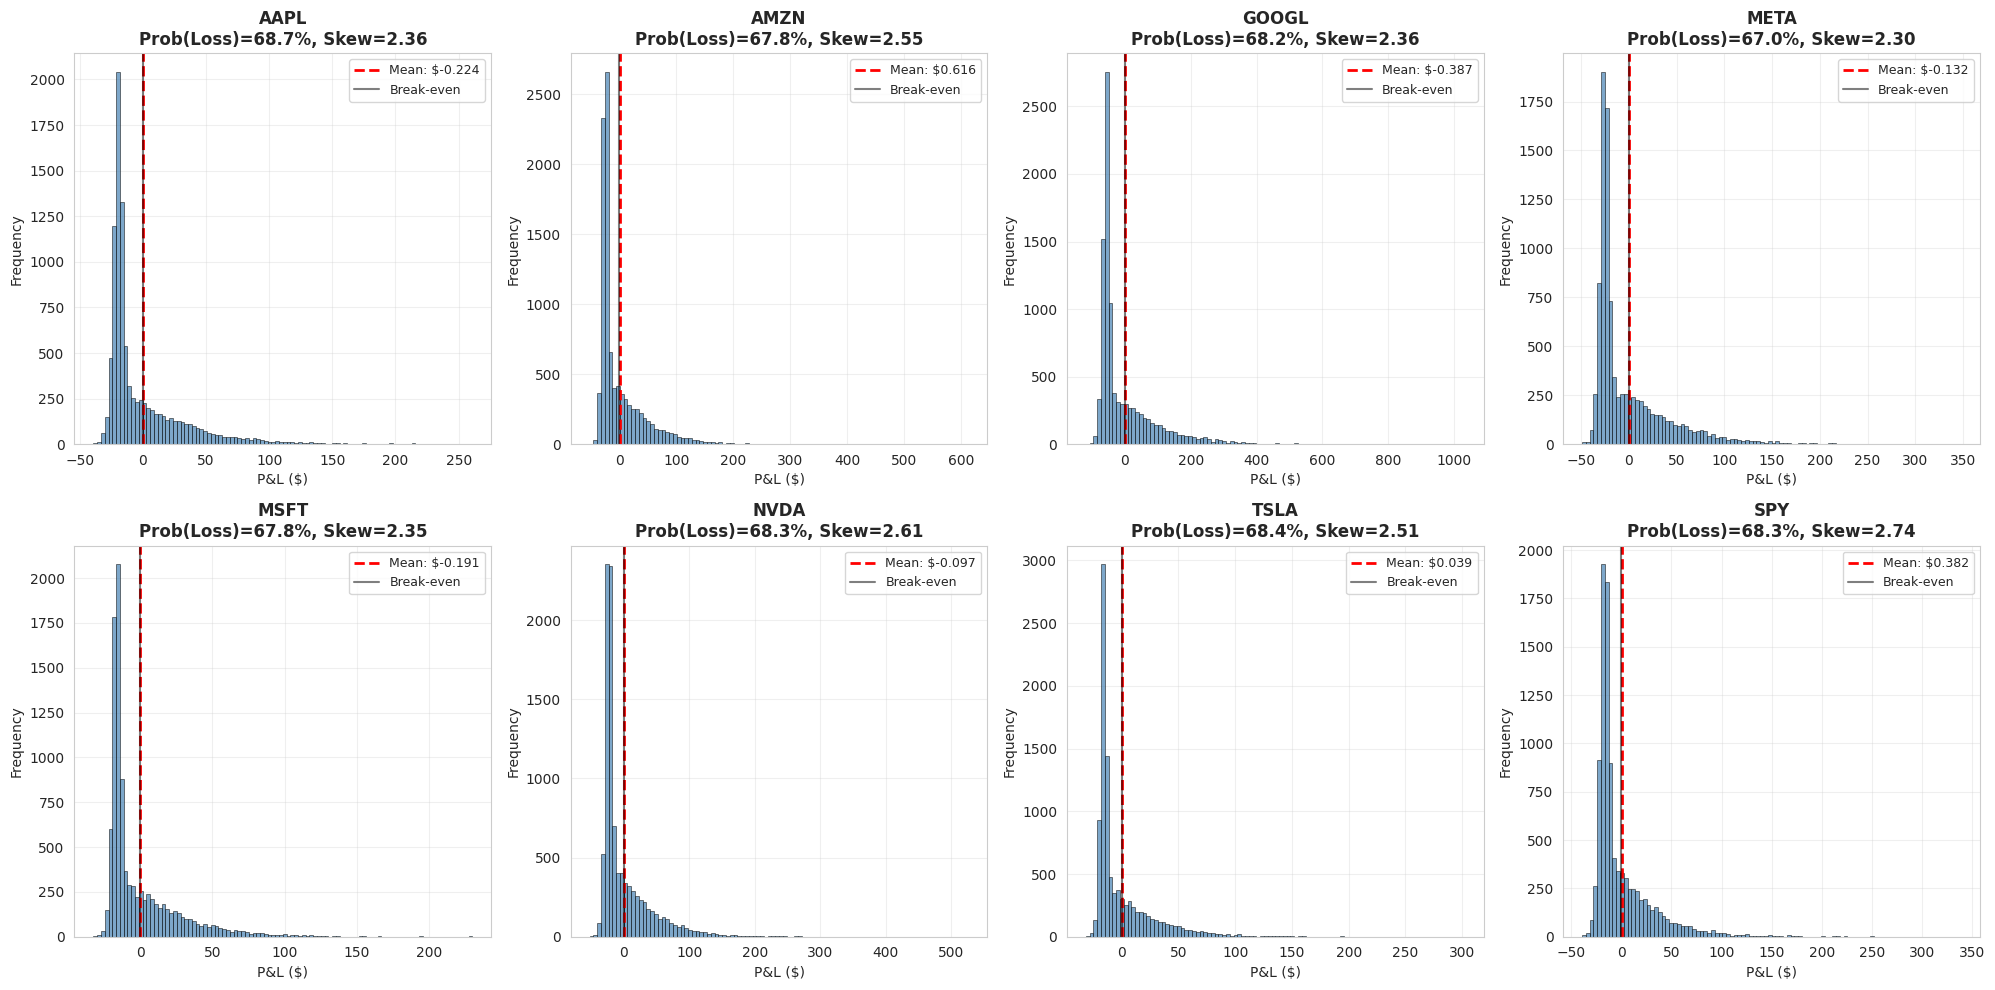

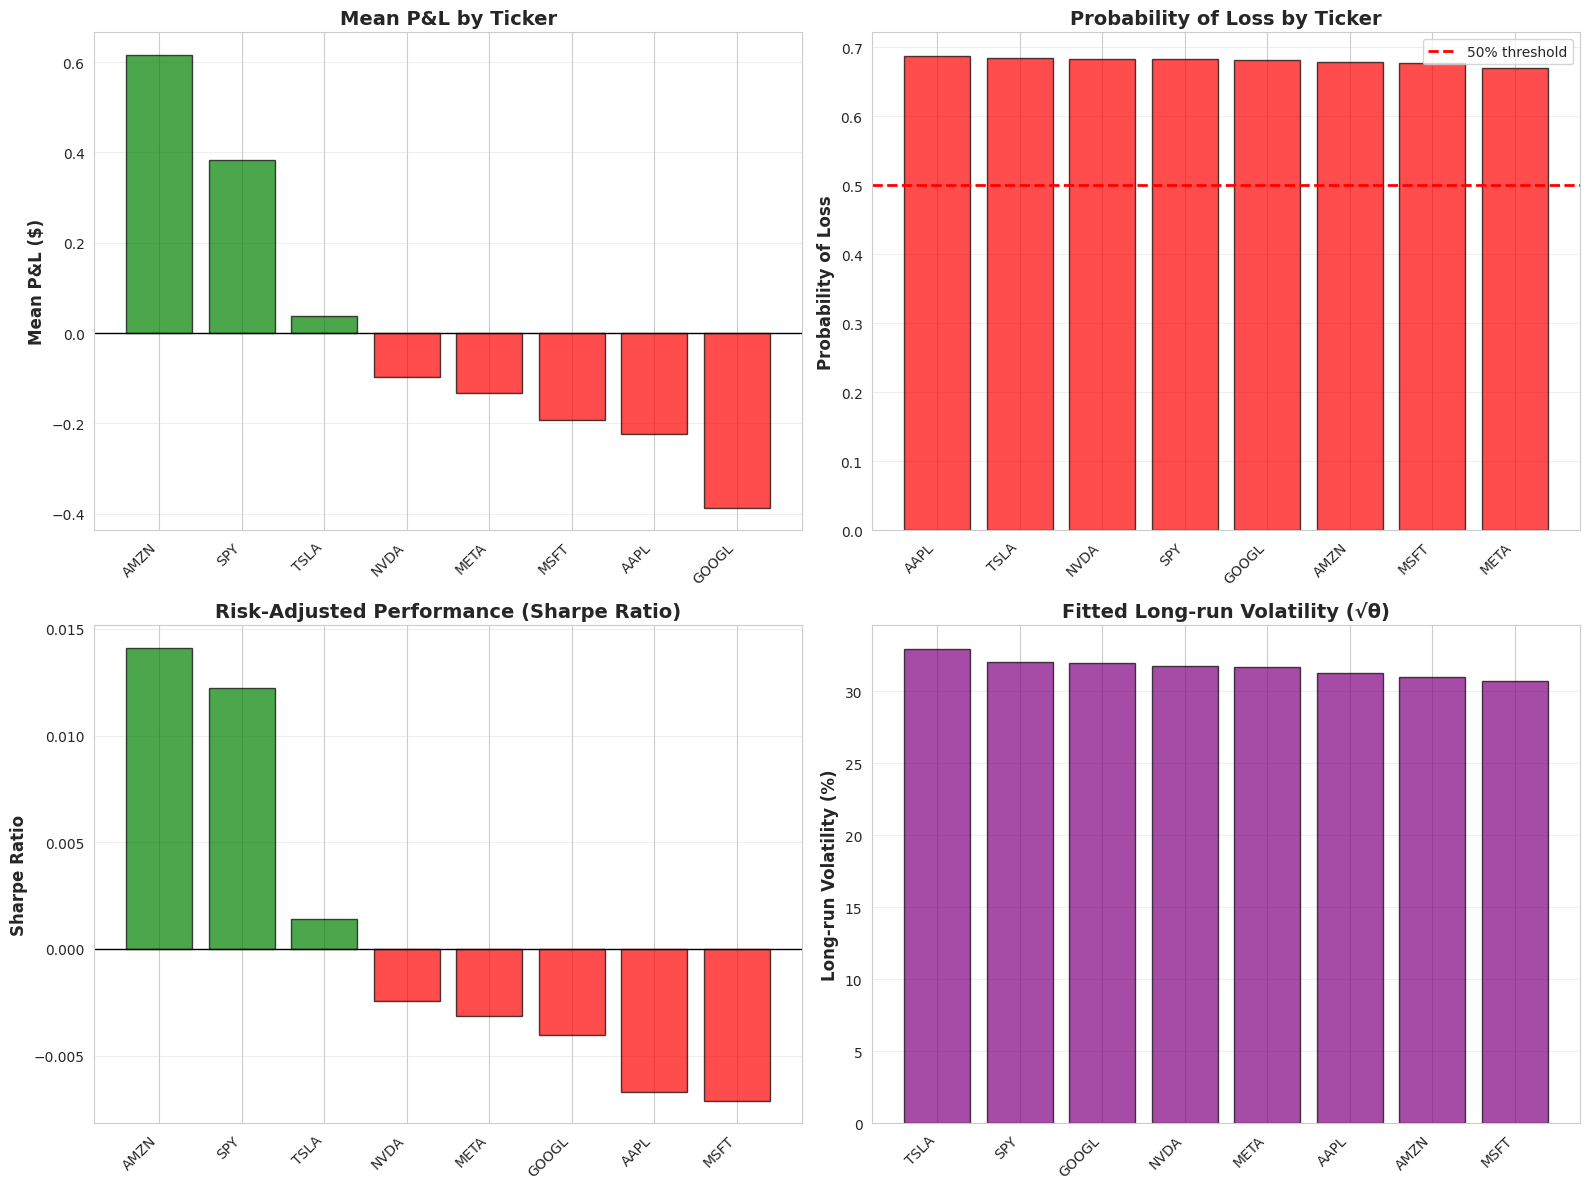

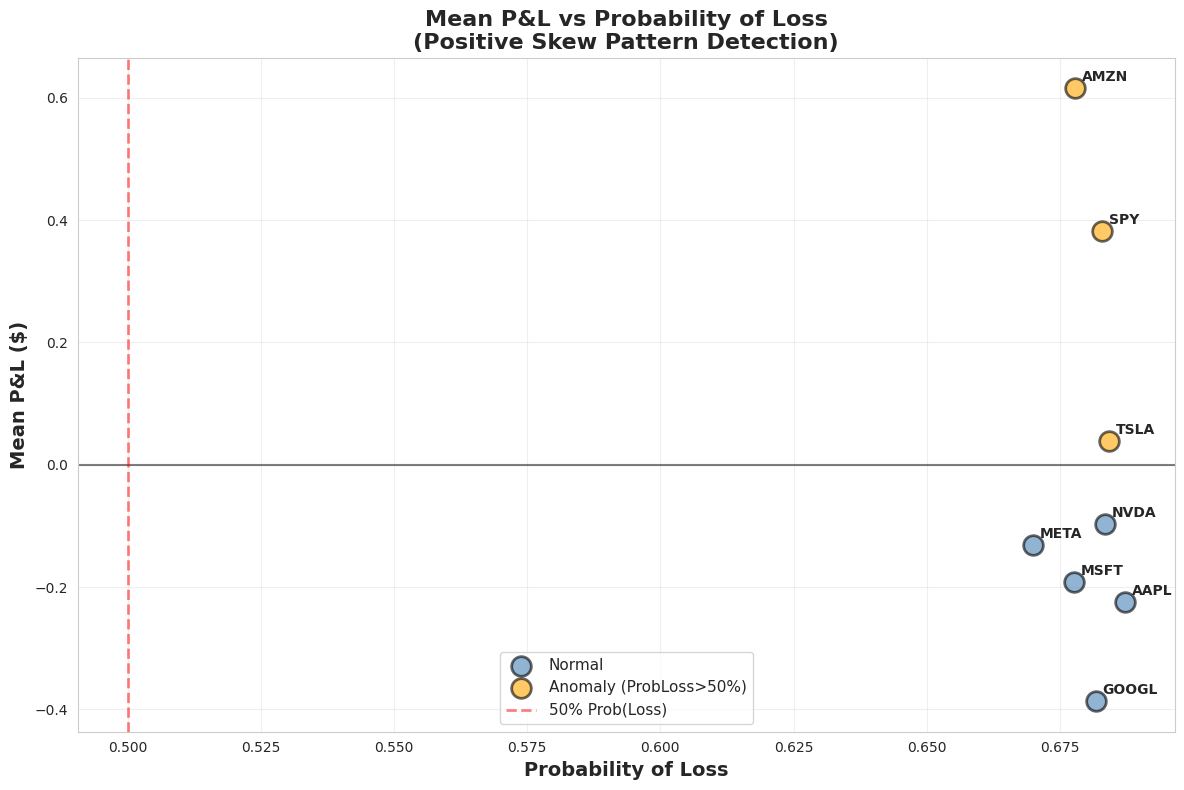

/tmp/ipython-input-2938520335.py:130: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(pnl_data, labels=tickers, patch_artist=True, showmeans=True,


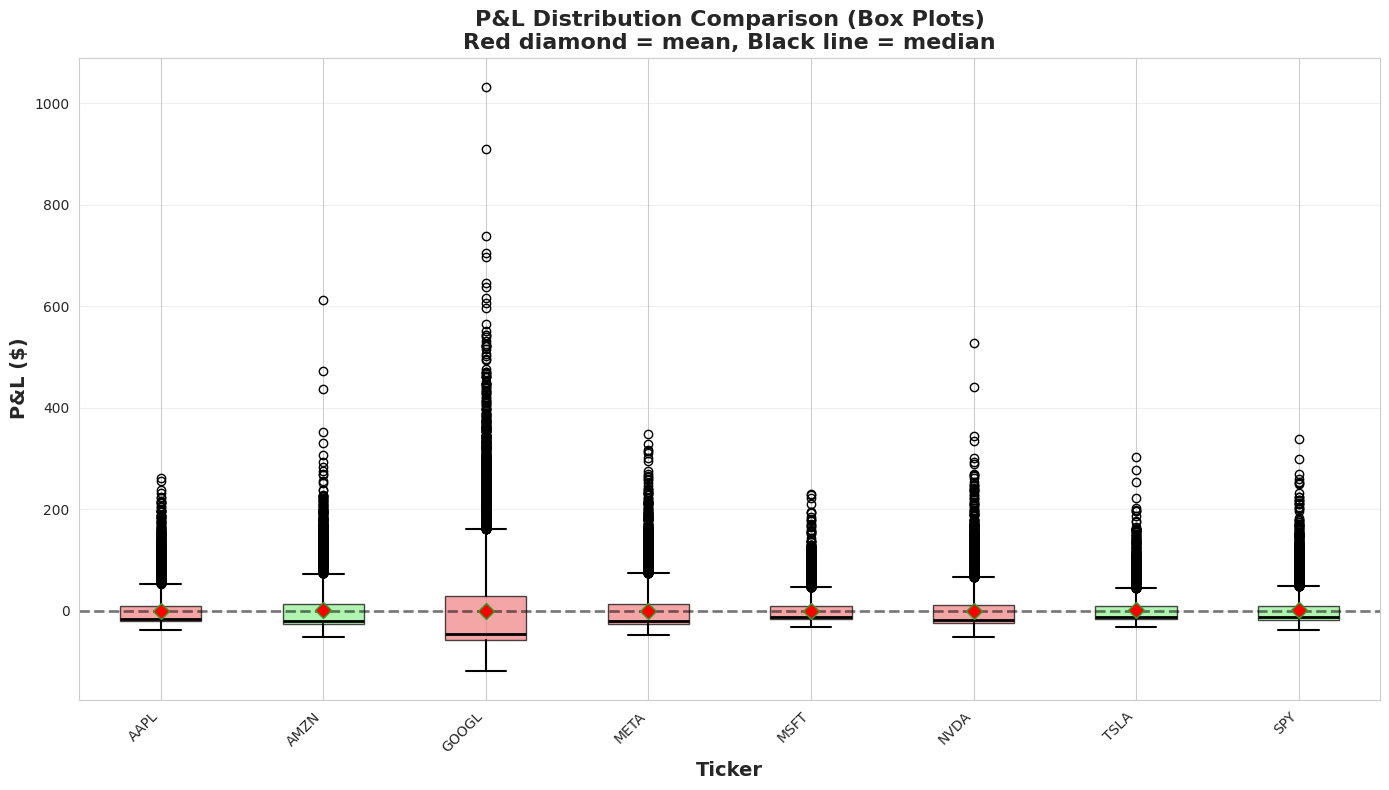

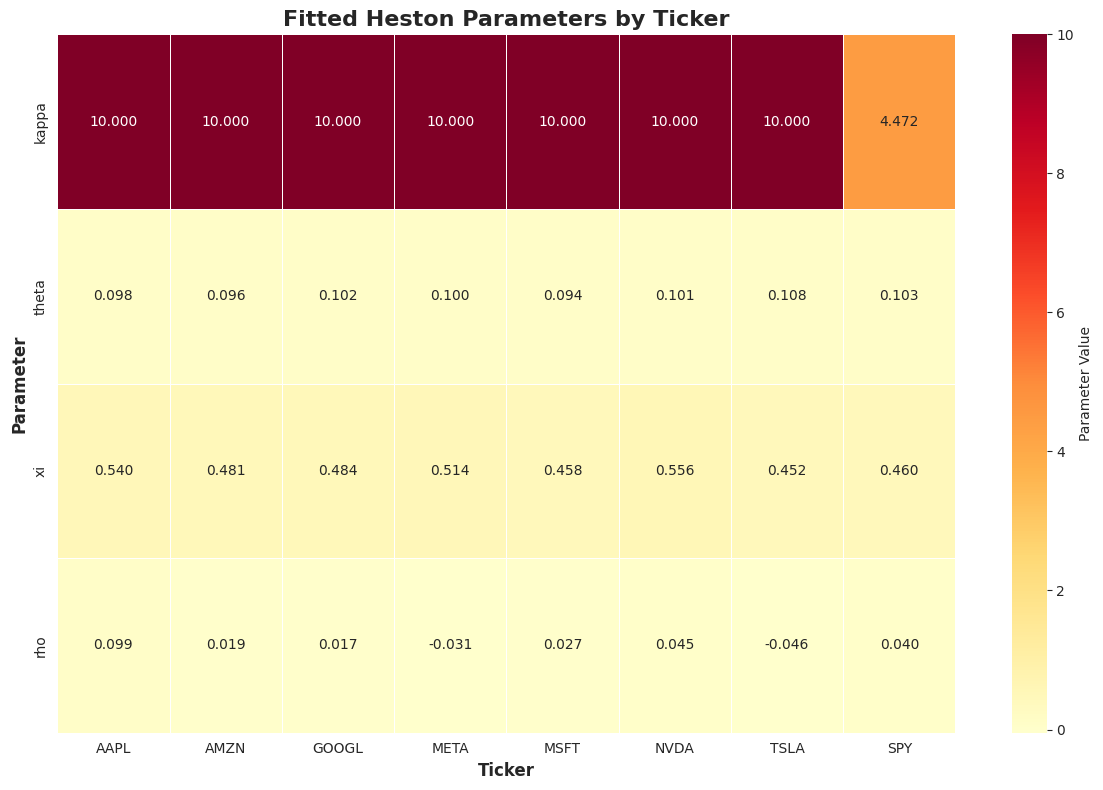

        MeanPnL  StdPnL  ProbLoss    MinPnL    MaxPnL  Premium   kappa  theta  \
Ticker                                                                          
AAPL    -0.2243 33.4806    0.6872  -39.1589  260.8221  19.2822 10.0000 0.0976   
AMZN     0.6157 43.6351    0.6779  -51.8472  612.6693  24.3471 10.0000 0.0959   
GOOGL   -0.3865 96.2091    0.6817 -118.3723 1032.3844  55.2982 10.0000 0.1021   
META    -0.1316 41.9766    0.6700  -49.0074  347.9930  24.8253 10.0000 0.1003   
MSFT    -0.1914 26.9226    0.6776  -32.3241  229.9285  15.7644 10.0000 0.0943   
NVDA    -0.0973 40.3061    0.6835  -52.2953  526.3408  22.8341 10.0000 0.1008   
TSLA     0.0385 27.6436    0.6842  -31.6753  302.4050  15.6025 10.0000 0.1084   
SPY      0.3821 31.2274    0.6830  -39.2279  339.0055  16.7372  4.4724 0.1026   

           xi     rho  
Ticker                 
AAPL   0.5395  0.0988  
AMZN   0.4807  0.0188  
GOOGL  0.4837  0.0168  
META   0.5136 -0.0312  
MSFT   0.4578  0.0274  
NVDA   0.5558  0.0450

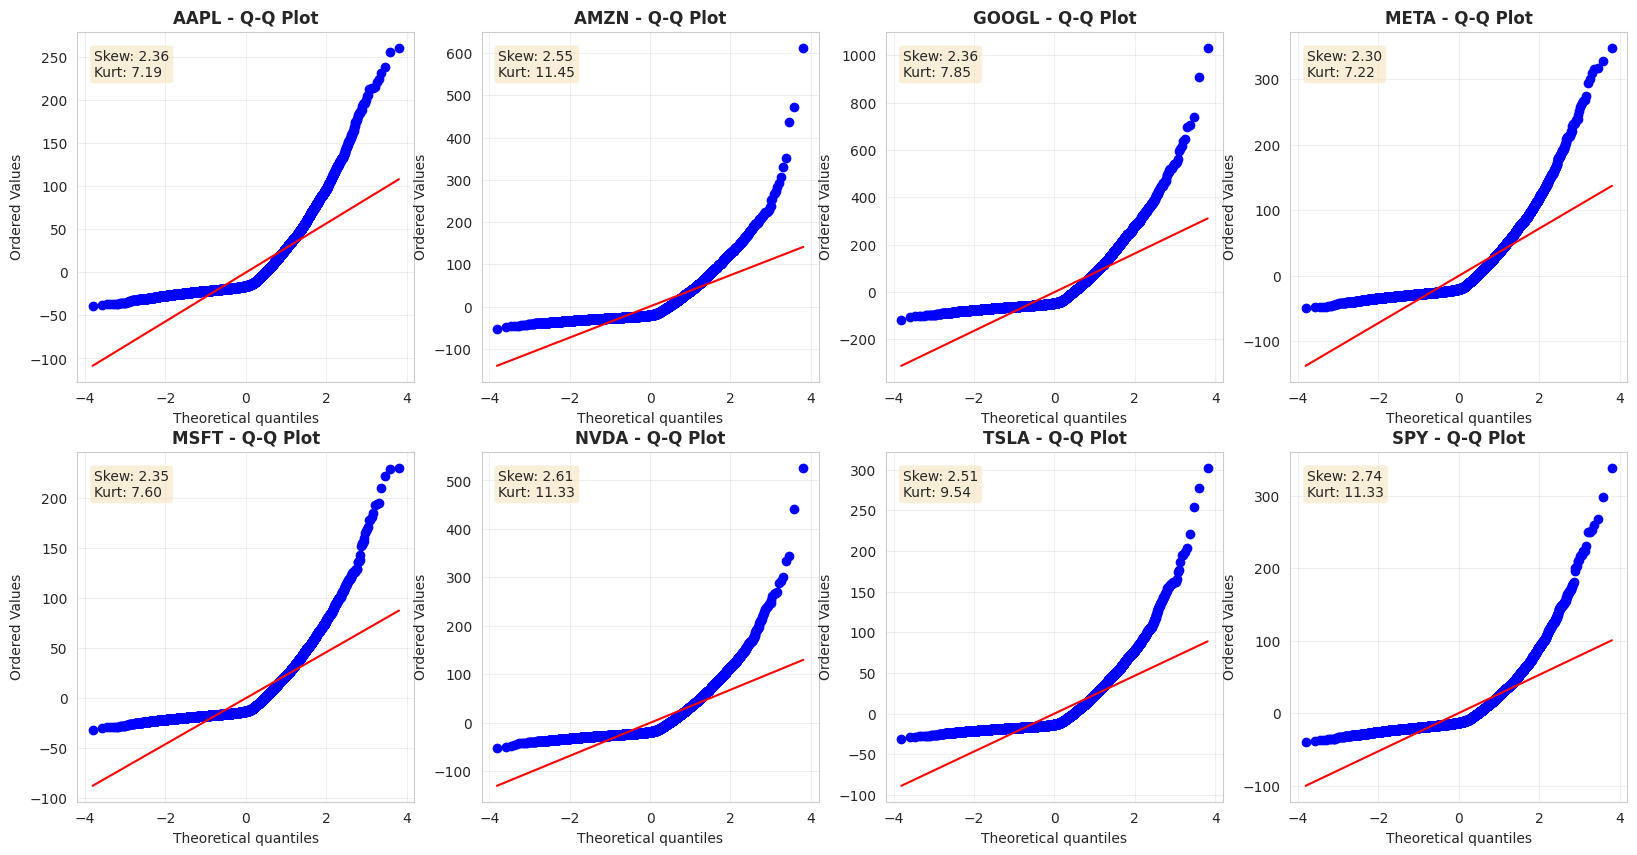

In [109]:
def plot_pnl_diagnostics(df_res, pnls, tickers, save_path=None):
    sns.set_style("whitegrid")
    plt.rcParams['figure.facecolor'] = 'white'
    n_tickers = len(tickers)
    n_cols = 4
    n_rows = int(np.ceil(n_tickers / n_cols))

    fig1, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_tickers > 1 else [axes]

    for idx, ticker in enumerate(tickers):
        ax = axes[idx]
        pnl = pnls[ticker]

        ax.hist(pnl, bins=100, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)

        mean_pnl = np.mean(pnl)
        ax.axvline(mean_pnl, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: ${mean_pnl:.3f}')
        ax.axvline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5,
                  label='Break-even')

        prob_loss = np.mean(pnl < 0)
        std_pnl = np.std(pnl)
        skewness = stats.skew(pnl)

        ax.set_title(f'{ticker}\nProb(Loss)={prob_loss:.1%}, Skew={skewness:.2f}',
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('P&L ($)', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.legend(fontsize=9, loc='best')
        ax.grid(alpha=0.3)

    for idx in range(n_tickers, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    fig2, axes = plt.subplots(2, 2, figsize=(16, 12))

    ax = axes[0, 0]
    sorted_by_mean = df_res.sort_values('MeanPnL', ascending=False)
    colors = ['green' if x > 0 else 'red' for x in sorted_by_mean['MeanPnL']]
    bars = ax.bar(range(len(sorted_by_mean)), sorted_by_mean['MeanPnL'],
                  color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(sorted_by_mean)))
    ax.set_xticklabels(sorted_by_mean.index, rotation=45, ha='right')
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('Mean P&L ($)', fontsize=12, fontweight='bold')
    ax.set_title('Mean P&L by Ticker', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

    ax = axes[0, 1]
    sorted_by_prob = df_res.sort_values('ProbLoss', ascending=False)
    colors = ['red' if x > 0.5 else 'orange' if x > 0.45 else 'green'
              for x in sorted_by_prob['ProbLoss']]
    bars = ax.bar(range(len(sorted_by_prob)), sorted_by_prob['ProbLoss'],
                  color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(sorted_by_prob)))
    ax.set_xticklabels(sorted_by_prob.index, rotation=45, ha='right')
    ax.axhline(0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
    ax.set_ylabel('Probability of Loss', fontsize=12, fontweight='bold')
    ax.set_title('Probability of Loss by Ticker', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3, axis='y')

    ax = axes[1, 0]
    sharpe_ratios = df_res['MeanPnL'] / df_res['StdPnL']
    sorted_by_sharpe = sharpe_ratios.sort_values(ascending=False)
    colors = ['green' if x > 0 else 'red' for x in sorted_by_sharpe]
    bars = ax.bar(range(len(sorted_by_sharpe)), sorted_by_sharpe,
                  color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(sorted_by_sharpe)))
    ax.set_xticklabels(sorted_by_sharpe.index, rotation=45, ha='right')
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
    ax.set_title('Risk-Adjusted Performance (Sharpe Ratio)', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

    ax = axes[1, 1]
    sorted_by_theta = df_res.sort_values('theta', ascending=False)
    ann_vols = np.sqrt(sorted_by_theta['theta']) * 100
    bars = ax.bar(range(len(sorted_by_theta)), ann_vols,
                  color='purple', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(sorted_by_theta)))
    ax.set_xticklabels(sorted_by_theta.index, rotation=45, ha='right')
    ax.set_ylabel('Long-run Volatility (%)', fontsize=12, fontweight='bold')
    ax.set_title('Fitted Long-run Volatility (√θ)', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()
    fig3, ax = plt.subplots(figsize=(12, 8))
    anomalies = (df_res['ProbLoss'] > 0.5) & (df_res['MeanPnL'] > 0)
    normal = ~anomalies

    ax.scatter(df_res.loc[normal, 'ProbLoss'], df_res.loc[normal, 'MeanPnL'],
               s=200, alpha=0.6, c='steelblue', edgecolors='black', linewidth=2,
               label='Normal')

    if anomalies.any():
        ax.scatter(df_res.loc[anomalies, 'ProbLoss'], df_res.loc[anomalies, 'MeanPnL'],
                   s=200, alpha=0.6, c='orange', edgecolors='black', linewidth=2,
                   label='Anomaly (ProbLoss>50%)')

    ax.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
    ax.axvline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.5,
              label='50% Prob(Loss)')

    for ticker in df_res.index:
        ax.annotate(ticker,
                   (df_res.loc[ticker, 'ProbLoss'], df_res.loc[ticker, 'MeanPnL']),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=10, fontweight='bold')

    ax.set_xlabel('Probability of Loss', fontsize=14, fontweight='bold')
    ax.set_ylabel('Mean P&L ($)', fontsize=14, fontweight='bold')
    ax.set_title('Mean P&L vs Probability of Loss\n(Positive Skew Pattern Detection)',
                 fontsize=16, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
    fig4, ax = plt.subplots(figsize=(14, 8))

    pnl_data = [pnls[ticker] for ticker in tickers]

    bp = ax.boxplot(pnl_data, labels=tickers, patch_artist=True, showmeans=True,
                    meanprops=dict(marker='D', markerfacecolor='red', markersize=8),
                    medianprops=dict(color='black', linewidth=2),
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))

    for i, ticker in enumerate(tickers):
        mean_pnl = df_res.loc[ticker, 'MeanPnL']
        bp['boxes'][i].set_facecolor('lightgreen' if mean_pnl > 0 else 'lightcoral')

    ax.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)
    ax.set_ylabel('P&L ($)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Ticker', fontsize=14, fontweight='bold')
    ax.set_title('P&L Distribution Comparison (Box Plots)\nRed diamond = mean, Black line = median',
                 fontsize=16, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()
    fig5, ax = plt.subplots(figsize=(12, 8))
    param_cols = ['kappa', 'theta', 'xi', 'rho']
    param_matrix = df_res[param_cols].T

    sns.heatmap(param_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
                linewidths=0.5, cbar_kws={'label': 'Parameter Value'},
                ax=ax)

    ax.set_title('Fitted Heston Parameters by Ticker', fontsize=16, fontweight='bold')
    ax.set_ylabel('Parameter', fontsize=12, fontweight='bold')
    ax.set_xlabel('Ticker', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    fig6, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_tickers > 1 else [axes]

    for idx, ticker in enumerate(tickers):
        ax = axes[idx]
        pnl = pnls[ticker]

        stats.probplot(pnl, dist="norm", plot=ax)
        ax.set_title(f'{ticker} - Q-Q Plot', fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)

        skewness = stats.skew(pnl)
        kurtosis = stats.kurtosis(pnl)
        ax.text(0.05, 0.95, f'Skew: {skewness:.2f}\nKurt: {kurtosis:.2f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=10)

    for idx in range(n_tickers, len(axes)):
        axes[idx].axis('off')

    summary_stats = []
    for ticker in tickers:
        pnl = pnls[ticker]

        var_95 = np.percentile(pnl, 5)
        cvar_95 = np.mean(pnl[pnl <= var_95])

        stats_dict = {
            'Ticker': ticker,
            'Mean': np.mean(pnl),
            'Median': np.median(pnl),
            'Std': np.std(pnl),
            'Skewness': stats.skew(pnl),
            'Kurtosis': stats.kurtosis(pnl),
            'Min': np.min(pnl),
            'Q25': np.percentile(pnl, 25),
            'Q75': np.percentile(pnl, 75),
            'Max': np.max(pnl),
            'Prob(Loss)': np.mean(pnl < 0),
            'Sharpe': np.mean(pnl) / np.std(pnl) if np.std(pnl) > 0 else 0,
            'VaR95': var_95,
            'CVaR95': cvar_95
        }
        summary_stats.append(stats_dict)

    summary_df = pd.DataFrame(summary_stats).set_index('Ticker')

    return summary_df

np.random.seed(42)
dates = pd.date_range(end=pd.Timestamp.today(), periods=500, freq='D')

data_close = pd.DataFrame({
        ticker: 100 * np.exp(np.cumsum(np.random.normal(0.0005, 0.02, 500)))
        for ticker in tickers
    }, index=dates)

df_res, pnls = heston_experiment(
        data_close, tickers,
        n_sims=10000,
        n_steps=252,
        r=0.035,
        transaction_cost=0.00035,
        random_seed=42
    )

summary_df = plot_pnl_diagnostics(
        df_res,
        pnls,
        tickers,
        save_path='heston_results'
    )
print(df_res)

# **The GARCH Model**

The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model is widely used in financial econometrics to model and forecast time-varying volatility in asset returns. The GARCH$(p, q)$ model assumes that the conditional variance of a time series depends not only on past squared residuals, but also on its own past values.

Let $\{r_t\}$ denote a mean-zero return series. The GARCH$(p, q)$ process is defined as
\begin{align}
    r_t &= \sigma_t \varepsilon_t, \quad \varepsilon_t \sim \text{i.i.d. }(0,1), \\
    \sigma_t^2 &= \omega + \sum_{i=1}^{q} \alpha_i r_{t-i}^2 + \sum_{j=1}^{p} \beta_j \sigma_{t-j}^2,
\end{align}
where $\omega > 0$, $\alpha_i \geq 0$, and $\beta_j \geq 0$.


We use the GARCH model to predict volatility. Then, we use this $\sigma$ to price the call options using the Black-Scholes model. We update the volatility by using rolling Garch windows of $21$ days, and use this to estimate the profit of delta-hedging.

GARCH DELTA HEDGING ANALYSIS
  Ticker  Premium  CallPayout  HedgePnL  TransactionCosts   NetPnL  MeanVol  \
0   AAPL   4.2071      0.0000  -10.5880            0.2454  -6.3809   0.0203   
1   AMZN   7.1034    194.6572  372.5173            0.1947 184.9635   0.0206   
2  GOOGL   6.9514    102.1740  167.0304            0.8473  71.8078   0.0196   
3   META   3.4771      8.5512   -4.8009            0.5365  -9.8750   0.0196   
4   MSFT   7.6561      0.0000  -35.1785            0.5789 -27.5223   0.0205   
5   NVDA   3.6484     29.7865    8.7617            0.8987 -17.3765   0.0218   
6   TSLA   2.6488      0.0000  -40.9018            0.8702 -38.2530   0.0180   
7    SPY   2.2075      0.0000   -5.4710            0.1186  -3.2635   0.0200   

   StdVol  FinalPrice   Strike  
0  0.0000    114.7710 121.1099  
1  0.0000    398.8457 204.1885  
2  0.0000    302.6030 200.4290  
3  0.0000    108.8051 100.2539  
4  0.0000    202.8381 220.2655  
5  0.0000    134.3278 104.5413  
6  0.0003     67.7638  76.53

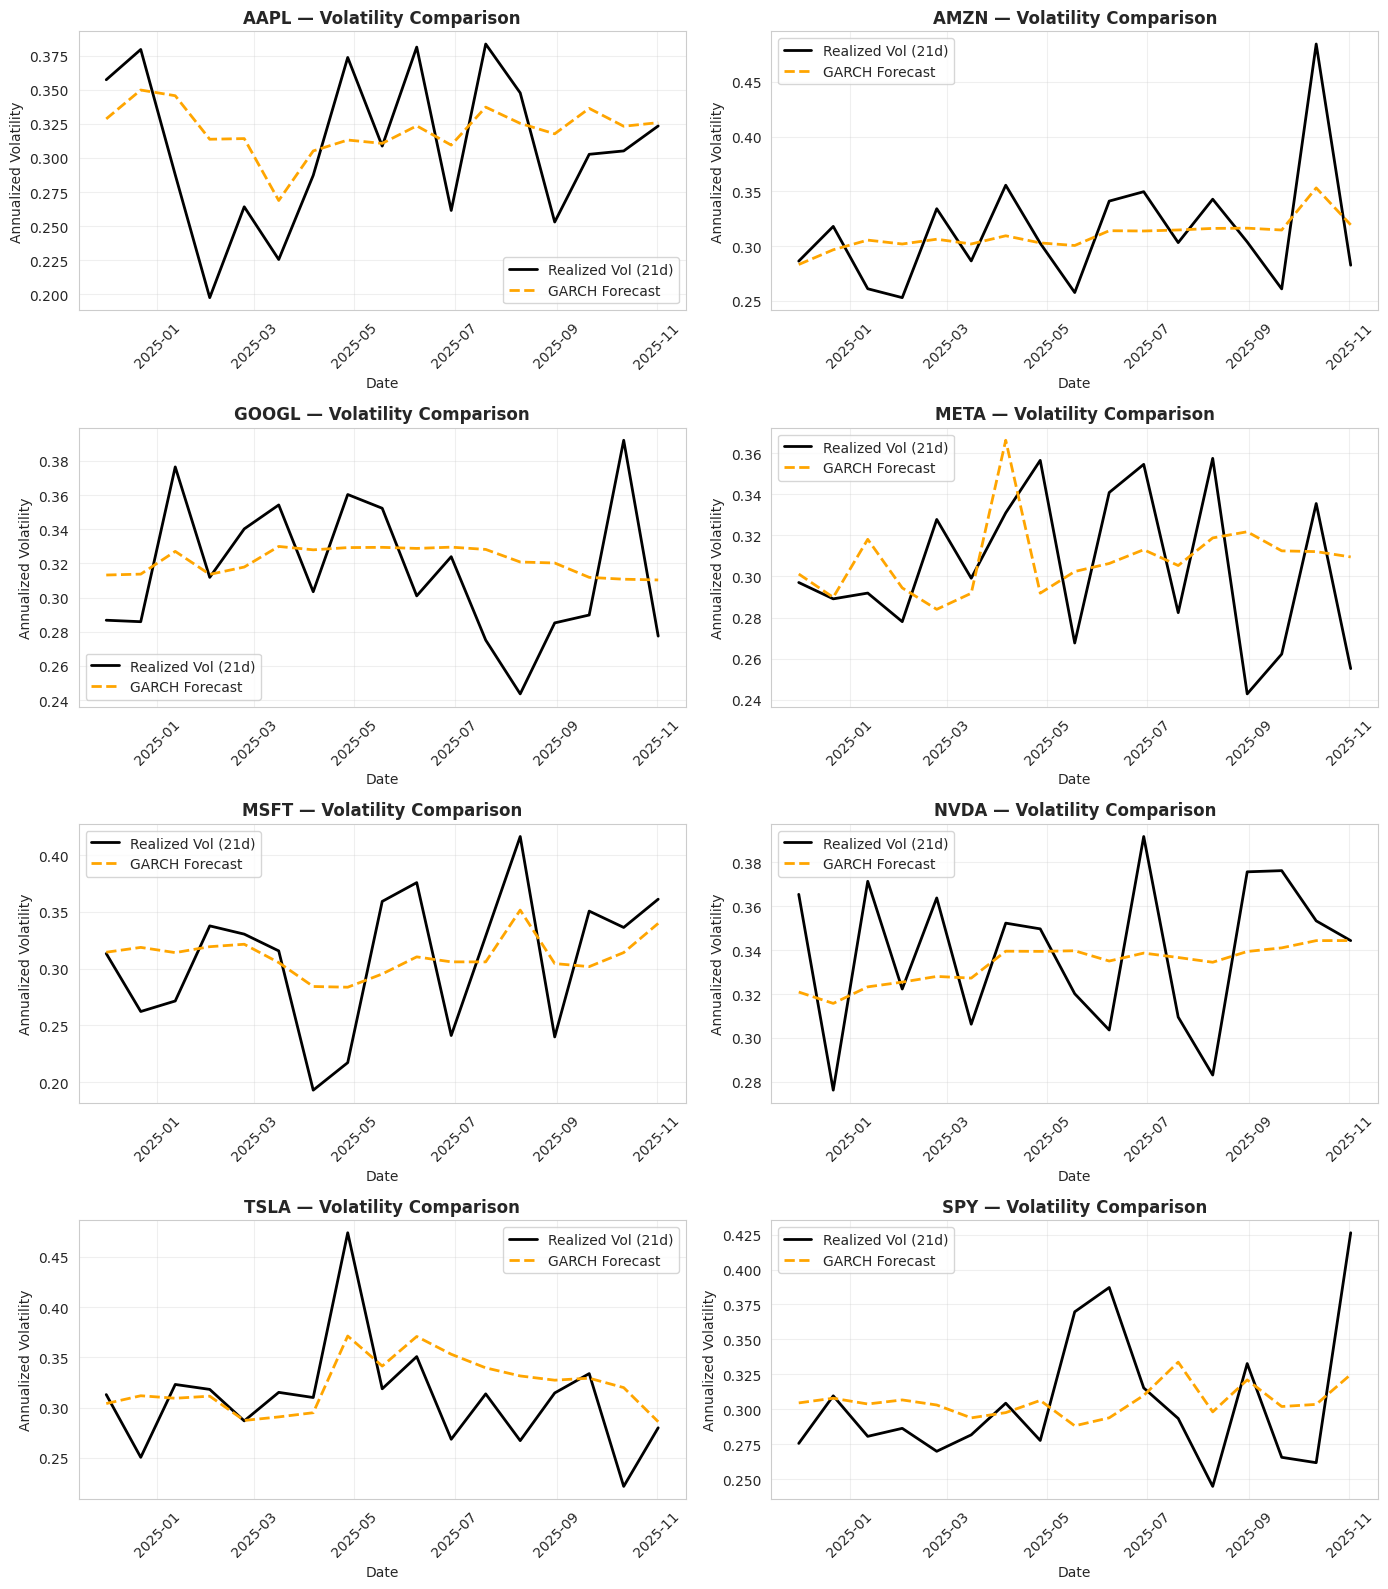

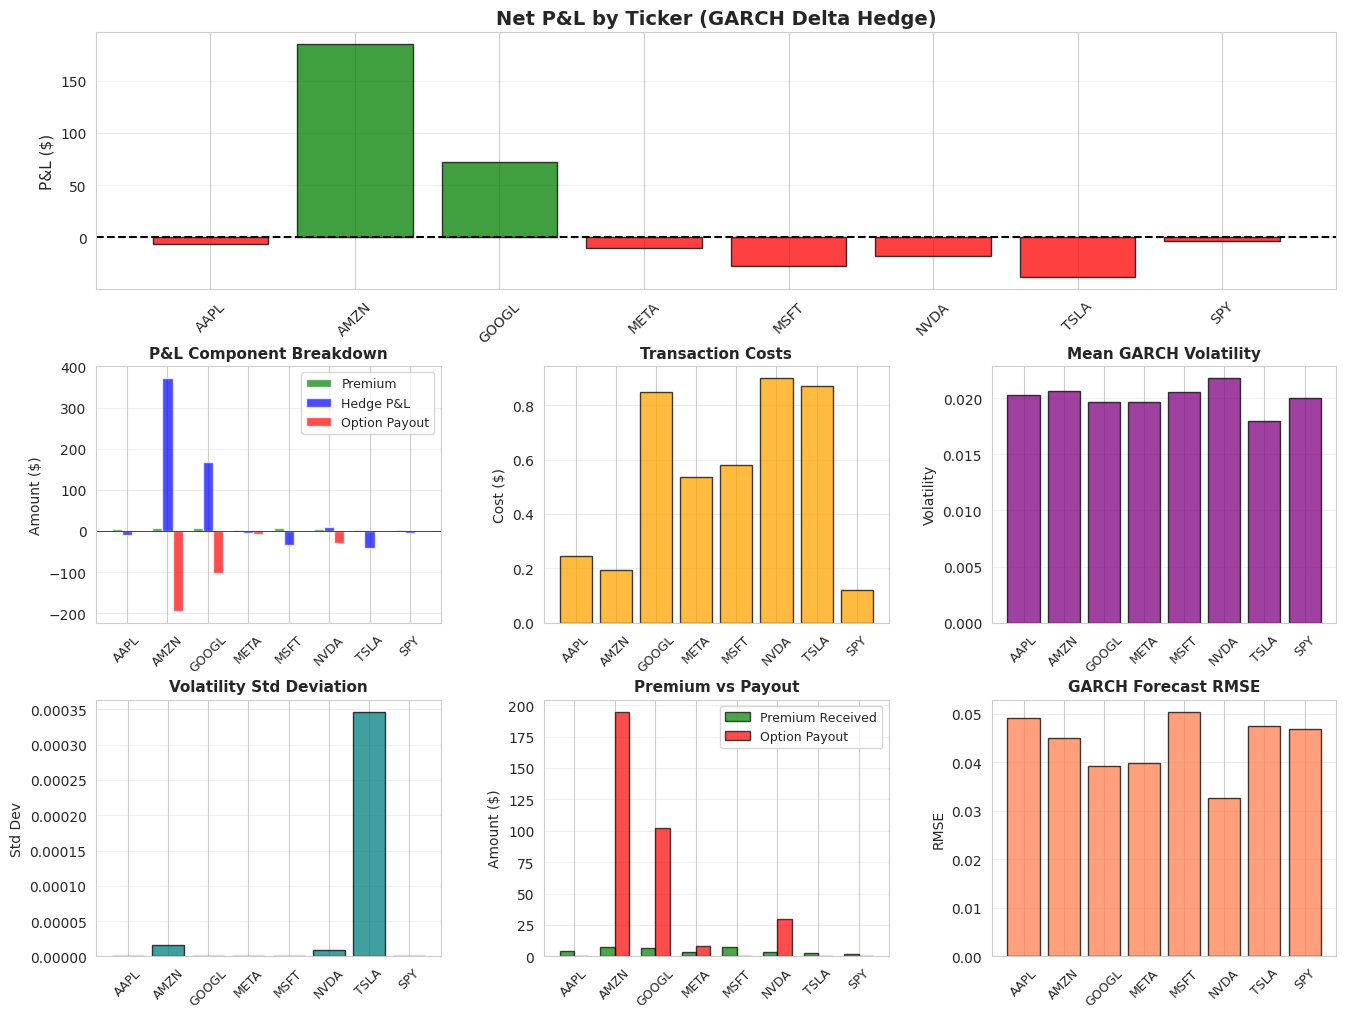

In [110]:
def fit_garch_and_forecast(sub_returns, n_steps):
    try:
        model = arch_model(sub_returns, vol="Garch", p=1, q=1, mean="Zero")
        res = model.fit(disp="off")
        forecast = res.forecast(horizon=n_steps)
        sigma_forecast = np.sqrt(forecast.variance.values[-1, :]) / 100
        return sigma_forecast
    except Exception:
        return np.full(n_steps, np.nan)


def rolling_garch_delta_hedge(data_close, tickers,
                                       r=0.035, t=1, n_steps=252,
                                       refit_freq=21, n_jobs=-1,
                                       transaction_cost=5):

    dt = t / n_steps
    results = []

    for ticker in tickers:
        prices_full = data_close[ticker].dropna().values
        if len(prices_full) < n_steps + 300:
            print(f"Not enough data for {ticker}")
            continue

        prices_full = prices_full[-(n_steps + 300):]
        returns = np.log(prices_full[1:] / prices_full[:-1]) * 100

        idxs = list(range(0, len(returns) - n_steps, refit_freq))
        sub_windows = [returns[i:i + n_steps] for i in idxs if len(returns[i:i + n_steps]) >= 50]

        if len(sub_windows) == 0:
            print(f"Not enough windows for {ticker}")
            continue

        forecasts = Parallel(n_jobs=n_jobs, backend="loky", verbose=0)(
            delayed(fit_garch_and_forecast)(sub_r, n_steps) for sub_r in sub_windows
        )

        if len(forecasts) > 0 and forecasts[-1] is not None:
            sigmas_raw = forecasts[-1]
        else:
            sigmas_raw = np.full(n_steps, np.nan)

        sigmas_raw = pd.Series(sigmas_raw).ffill().bfill().values
        sigmas_raw = np.clip(sigmas_raw, 1e-6, None)
        sigmas_raw = sigmas_raw[:n_steps]

        prices = prices_full[-(n_steps + 1):]
        S0 = prices[0]
        K = S0
        sigma0 = sigmas_raw[0]
        premium0 = bs_call(S0, K, sigma0, t, r)

        sigmas = sigmas_raw

        taus = np.maximum(t - np.arange(n_steps) * dt, dt/2)

        S_t = prices[:-1]
        d1_series = (np.log(S_t / K) + (r + 0.5 * sigmas**2) * taus) / (sigmas * np.sqrt(taus))
        deltas = norm.cdf(d1_series)

        portfolio_value = 0
        hedge_position = 0
        total_transaction_costs = 0

        for i in range(n_steps):
            delta_current = deltas[i]
            S_current = S_t[i]

            shares_to_trade = delta_current - hedge_position
            trade_cost = abs(shares_to_trade) * S_current * (transaction_cost / 10000)

            portfolio_value -= shares_to_trade * S_current
            portfolio_value -= trade_cost
            total_transaction_costs += trade_cost

            hedge_position = delta_current

            if i < n_steps - 1:
                S_next = prices[i + 1]
                hedge_pnl = hedge_position * (S_next - S_current)
                portfolio_value += hedge_pnl
        S_T = prices[-1]
        portfolio_value += hedge_position * S_T

        call_payout = max(S_T - K, 0)

        net_pnl = premium0 + portfolio_value - call_payout

        results.append({
            "Ticker": ticker,
            "Premium": premium0,
            "CallPayout": call_payout,
            "HedgePnL": portfolio_value,
            "TransactionCosts": total_transaction_costs,
            "NetPnL": net_pnl,
            "MeanVol": np.mean(sigmas),
            "StdVol": np.std(sigmas),
            "FinalPrice": S_T,
            "Strike": K
        })

    return pd.DataFrame(results)

def compute_vol_comparison(data_close, tickers, refit_freq=21):
    vol_data = []

    for ticker in tickers:
        prices = data_close[ticker].dropna()
        returns = np.log(prices / prices.shift(1)).dropna()

        realized_vol = returns.rolling(21).std() * np.sqrt(252)

        garch_vols = []
        dates = []

        for i in range(252, len(returns), refit_freq):
            ret_window = returns.iloc[i-252:i].dropna() * 100
            if len(ret_window) < 20:
                continue

            try:
                model = arch_model(ret_window, vol='Garch', p=1, q=1, mean='Zero')
                res = model.fit(disp='off')
                forecast = res.forecast(horizon=1)
                forecast_vol = np.sqrt(forecast.variance.values[-1, 0]) / 100 * np.sqrt(252)
                garch_vols.append(forecast_vol)
                dates.append(returns.index[i])
            except:
                continue

        realized_aligned = realized_vol.reindex(dates).values

        df = pd.DataFrame({
            "Date": dates,
            "Ticker": ticker,
            "RealizedVol": realized_aligned,
            "GARCHVol": garch_vols
        })
        vol_data.append(df)

    return pd.concat(vol_data, ignore_index=True)

def plot_volatility_comparison(df_vol_compare, tickers):
    sns.set_style("whitegrid")

    n_tickers = len(tickers)
    n_cols = 2
    n_rows = (n_tickers + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
    axes = axes.flatten() if n_tickers > 1 else [axes]

    for i, ticker in enumerate(tickers):
        df_sub = df_vol_compare[df_vol_compare["Ticker"] == ticker]

        if len(df_sub) == 0:
            continue

        ax = axes[i]
        ax.plot(df_sub["Date"], df_sub["RealizedVol"],
                label="Realized Vol (21d)", color="black", linewidth=2)
        ax.plot(df_sub["Date"], df_sub["GARCHVol"],
                label="GARCH Forecast", color="orange", linewidth=2, linestyle='--')
        ax.set_title(f"{ticker} — Volatility Comparison", fontweight='bold', fontsize=12)
        ax.set_ylabel("Annualized Volatility", fontsize=10)
        ax.set_xlabel("Date", fontsize=10)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


def plot_comprehensive_analysis(df_garch, df_vol_compare, tickers):
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, :])
    colors = ['green' if x >= 0 else 'red' for x in df_garch["NetPnL"]]
    ax1.bar(df_garch["Ticker"], df_garch["NetPnL"], color=colors, alpha=0.75, edgecolor='black')
    ax1.axhline(0, color='black', lw=1.5, linestyle='--')
    ax1.set_title("Net P&L by Ticker (GARCH Delta Hedge)", fontweight='bold', fontsize=14)
    ax1.set_ylabel("P&L ($)", fontsize=11)
    ax1.grid(True, axis='y', alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    ax2 = fig.add_subplot(gs[1, 0])
    x = np.arange(len(df_garch))
    width = 0.25
    ax2.bar(x - width, df_garch["Premium"], width, label='Premium', color='green', alpha=0.7)
    ax2.bar(x, df_garch["HedgePnL"], width, label='Hedge P&L', color='blue', alpha=0.7)
    ax2.bar(x + width, -df_garch["CallPayout"], width, label='Option Payout', color='red', alpha=0.7)
    ax2.axhline(0, color='black', lw=0.5)
    ax2.set_xticks(x)
    ax2.set_xticklabels(df_garch["Ticker"], rotation=45, fontsize=9)
    ax2.set_title("P&L Component Breakdown", fontweight='bold', fontsize=11)
    ax2.set_ylabel("Amount ($)", fontsize=10)
    ax2.legend(fontsize=9)
    ax2.grid(True, axis='y', alpha=0.3)

    ax3 = fig.add_subplot(gs[1, 1])
    ax3.bar(df_garch["Ticker"], df_garch["TransactionCosts"], color='orange', alpha=0.75, edgecolor='black')
    ax3.set_title("Transaction Costs", fontweight='bold', fontsize=11)
    ax3.set_ylabel("Cost ($)", fontsize=10)
    ax3.grid(True, axis='y', alpha=0.3)
    ax3.tick_params(axis='x', rotation=45, labelsize=9)

    ax4 = fig.add_subplot(gs[1, 2])
    ax4.bar(df_garch["Ticker"], df_garch["MeanVol"], alpha=0.75, color='purple', edgecolor='black')
    ax4.set_title("Mean GARCH Volatility", fontweight='bold', fontsize=11)
    ax4.set_ylabel("Volatility", fontsize=10)
    ax4.grid(True, axis='y', alpha=0.3)
    ax4.tick_params(axis='x', rotation=45, labelsize=9)

    ax5 = fig.add_subplot(gs[2, 0])
    ax5.bar(df_garch["Ticker"], df_garch["StdVol"], alpha=0.75, color='teal', edgecolor='black')
    ax5.set_title("Volatility Std Deviation", fontweight='bold', fontsize=11)
    ax5.set_ylabel("Std Dev", fontsize=10)
    ax5.grid(True, axis='y', alpha=0.3)
    ax5.tick_params(axis='x', rotation=45, labelsize=9)

    ax6 = fig.add_subplot(gs[2, 1])
    x = np.arange(len(df_garch))
    width = 0.35
    ax6.bar(x - width/2, df_garch["Premium"], width, label='Premium Received',
            color='green', alpha=0.7, edgecolor='black')
    ax6.bar(x + width/2, df_garch["CallPayout"], width, label='Option Payout',
            color='red', alpha=0.7, edgecolor='black')
    ax6.set_xticks(x)
    ax6.set_xticklabels(df_garch["Ticker"], rotation=45, fontsize=9)
    ax6.set_title("Premium vs Payout", fontweight='bold', fontsize=11)
    ax6.set_ylabel("Amount ($)", fontsize=10)
    ax6.legend(fontsize=9)
    ax6.grid(True, axis='y', alpha=0.3)

    ax7 = fig.add_subplot(gs[2, 2])
    rmse_by_ticker = []
    for ticker in tickers:
        df_sub = df_vol_compare[df_vol_compare["Ticker"] == ticker]
        if len(df_sub) > 0:
            realized = df_sub["RealizedVol"].dropna()
            garch = df_sub["GARCHVol"].dropna()
            min_len = min(len(realized), len(garch))
            if min_len > 0:
                rmse = np.sqrt(np.mean((realized[:min_len] - garch[:min_len])**2))
                rmse_by_ticker.append(rmse)
            else:
                rmse_by_ticker.append(0)
        else:
            rmse_by_ticker.append(0)

    ax7.bar(tickers, rmse_by_ticker, alpha=0.75, color='coral', edgecolor='black')
    ax7.set_title("GARCH Forecast RMSE", fontweight='bold', fontsize=11)
    ax7.set_ylabel("RMSE", fontsize=10)
    ax7.grid(True, axis='y', alpha=0.3)
    ax7.tick_params(axis='x', rotation=45, labelsize=9)
    plt.show()



if __name__ == "__main__":
    np.random.seed(42)
    dates = pd.date_range(end=pd.Timestamp.today(), periods=600, freq='D')

    data_close = pd.DataFrame({
        ticker: 100 * np.exp(np.cumsum(np.random.normal(0.0005, 0.02, 600)))
        for ticker in tickers
    }, index=dates)

    print("GARCH DELTA HEDGING ANALYSIS")

    df_garch = rolling_garch_delta_hedge(
        data_close, tickers,
        r=0.035, t=1, n_steps=252,
        refit_freq=21, n_jobs=-1,
        transaction_cost=5
    )

    print(df_garch.round(4))
    print(df_garch["NetPnL"].describe())
    df_vol_compare = compute_vol_comparison(data_close, tickers, refit_freq=21)
    plot_volatility_comparison(df_vol_compare, tickers)
    plot_comprehensive_analysis(df_garch, df_vol_compare, tickers)



The "stochastic alpha, beta, rho" (SABR) model is a stochastic volatility model, which attempts to capture the volatility smile in derivatives markets. It assumes that the forward price $F_t$ and its volatility $\sigma_t$ follow the system of stochastic differential equations:
\begin{align}
    dF_t &= \sigma_t F_t^{\beta} \, dW_t, \\
    d\sigma_t &= \nu \sigma_t \, dZ_t, \\
    \mathrm{corr}(dW_t, dZ_t) &= \rho,
\end{align}
where $\beta \in [0,1]$ controls the elasticity of volatility with respect to the underlying price, $\nu$ represents the volatility of volatility, and $\rho$ denotes the instantaneous correlation between the two Brownian motions $W_t$ and $Z_t$.

We simulate delta-hedging using the SABR model to estimate the volatilities of each ticker, and then calculate the resulting B-S price of the call options. Then, we perform the delta hedge and calculate the profit.

SABR Delta-Hedging Results
  Ticker      PnL  HedgePnL  OptionPayout  MeanAlpha  MeanVol  FinalPrice  \
0   AAPL  12.0008   39.3010       27.3002     0.3179   0.1050    112.3792   
1   AMZN -17.1532  -17.1532        0.0000     0.3104   0.0917    102.1283   
2  GOOGL  59.4117  141.9305       82.5188     0.3062   0.0951    190.2492   
3   META  90.4697  189.2675       98.7978     0.3123   0.1386    209.6438   
4   MSFT  64.5875  155.3292       90.7417     0.3116   0.1009    201.4384   
5   NVDA  32.1407   81.1184       48.9777     0.3038   0.1092    150.2211   
6   TSLA   4.8584   19.1275       14.2691     0.3102   0.1087    100.1734   
7    SPY -13.2262   -4.9834        8.2428     0.3105   0.0979    108.6167   

    Strike  
0  84.1066  
1 107.7689  
2 104.7911  
3 107.3268  
4 107.4645  
5  99.4989  
6  85.3960  
7 100.0803  


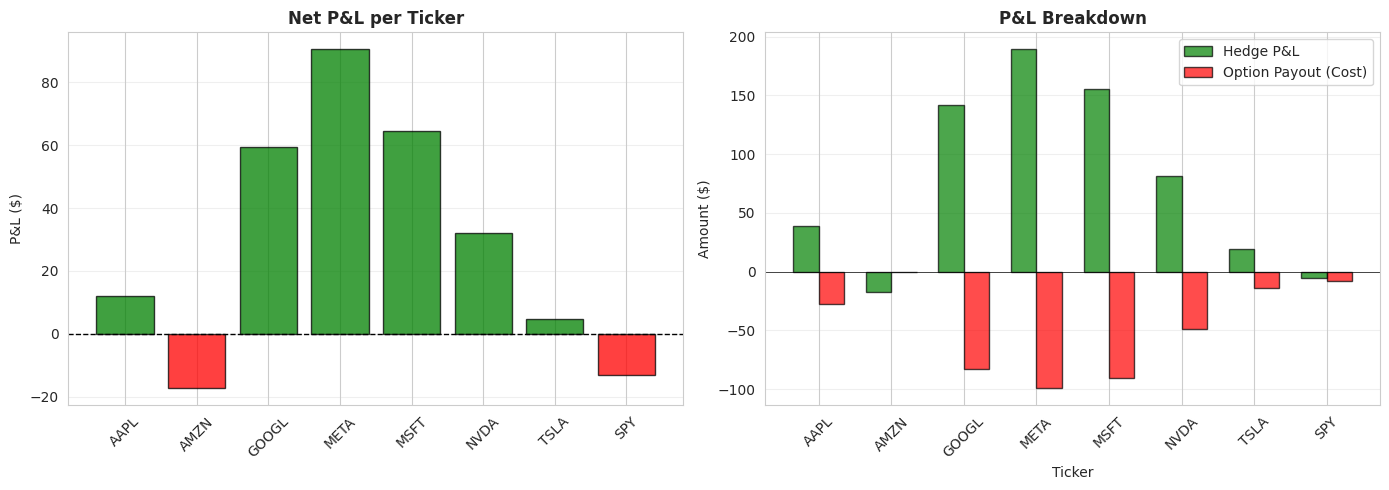

In [112]:
def sabr_implied_vol(F, K, T, alpha, beta, rho, nu):
    F, K, T = np.asarray(F), np.asarray(K), np.asarray(T)
    eps = 1e-12
    T = np.maximum(T, eps)
    F = np.maximum(F, eps)
    K = np.maximum(K, eps)
    out = np.zeros_like(F, dtype=float)

    atmf = np.isclose(F, K, rtol=1e-4)
    not_atmf = ~atmf

    if np.any(atmf):
        F_atm = F[atmf]
        T_atm = T[atmf]

        term1 = ((1 - beta)**2 / 24) * (alpha**2 / (F_atm**(2 - 2*beta)))
        term2 = (rho * beta * nu * alpha) / (4 * F_atm**(1 - beta))
        term3 = (2 - 3 * rho**2) * nu**2 / 24

        out[atmf] = (alpha / F_atm**(1 - beta)) * (1 + (term1 + term2 + term3) * T_atm)

    if np.any(not_atmf):
        F_ = F[not_atmf]
        K_ = K[not_atmf]
        T_ = T[not_atmf]
        FK = F_ * K_
        logFK = np.log(F_ / K_)

        z = (nu / alpha) * (FK)**((1 - beta)/2) * logFK

        sqrt_term = np.sqrt(1 - 2*rho*z + z**2)
        x_z = np.log((sqrt_term + z - rho) / (1 - rho))

        x_z = np.where(np.abs(x_z) < eps, z, x_z)

        denom = (FK)**((1 - beta)/2) * (
            1 + ((1 - beta)**2 / 24) * logFK**2 +
            ((1 - beta)**4 / 1920) * logFK**4
        )

        num = alpha * z / x_z

        correction = 1 + (
            ((1 - beta)**2 / 24) * (alpha**2 / (FK**(1 - beta))) +
            (rho * beta * nu * alpha) / (4 * FK**((1 - beta)/2)) +
            ((2 - 3*rho**2) * nu**2 / 24)
        ) * T_

        out[not_atmf] = num / denom * correction

    return np.nan_to_num(out, nan=np.nanmean(out[out>0]))


def sabr_delta_hedge(prices, K, r, T, alpha, beta, rho, nu):
    n_steps = len(prices) - 1
    dt = T / n_steps

    portfolio_value = 0
    hedge_position = 0

    for t in range(n_steps):
        S_t = prices[t]
        tau = T - t * dt

        if tau <= 0:
            break

        vol = sabr_implied_vol(S_t, K, tau, alpha, beta, rho, nu)
        d1 = (np.log(S_t/K) + (r + 0.5*vol**2)*tau) / (vol*np.sqrt(tau))
        delta = norm.cdf(d1)
        shares_to_trade = delta - hedge_position
        portfolio_value -= shares_to_trade * S_t
        hedge_position = delta

        if t < n_steps - 1:
            S_next = prices[t+1]
            hedge_pnl = hedge_position * (S_next - S_t)
            portfolio_value += hedge_pnl

    S_T = prices[-1]
    option_payoff = max(S_T - K, 0)
    portfolio_value += hedge_position * S_T

    net_pnl = portfolio_value - option_payoff
    return net_pnl

def sabr_vectorized_delta_hedge_all(data_close, tickers, r=0.035, t=1, n_steps=252,
                                    beta=0.7, rho=-0.4, nu=0.6, refit_freq=21):
    results = []
    dt = t / n_steps

    for ticker in tickers:
        prices = data_close[ticker].dropna().values
        prices = prices[-(n_steps+1):]
        K = prices[0]
        logret = np.diff(np.log(prices))
        roll_std = pd.Series(logret).rolling(window=refit_freq, min_periods=1).std()
        roll_alpha = (roll_std * np.sqrt(252)).ffill().bfill().clip(0.05, 1.0)
        alphas = roll_alpha.values[:n_steps]
        if len(alphas) < n_steps:
            alphas = np.pad(alphas, (0, n_steps - len(alphas)), mode='edge')

        taus = np.maximum(t - np.arange(n_steps) * dt, 1e-8)
        S_t = prices[:-1]
        sabr_vols = np.array([
            sabr_implied_vol(S_t[i], K, taus[i], alphas[i], beta, rho, nu)
            for i in range(n_steps)
        ])

        d1 = (np.log(S_t/K) + (r + 0.5*sabr_vols**2)*taus) / (sabr_vols*np.sqrt(taus))
        deltas = norm.cdf(d1)
        taus = np.maximum(t - np.arange(n_steps) * dt, 1e-8)
        S_t = prices[:-1]
        sabr_vols = np.array([
            sabr_implied_vol(S_t[i], K, taus[i], alphas[i], beta, rho, nu)
            for i in range(n_steps)
        ])
        d1 = (np.log(S_t/K) + (r + 0.5*sabr_vols**2)*taus) / (sabr_vols*np.sqrt(taus))
        deltas = norm.cdf(d1)
        deltas_held = np.concatenate(([0.0], deltas[:-1]))
        shares_traded = deltas - deltas_held
        price_changes = prices[1:] - prices[:-1]
        pnl_from_hold = deltas_held * price_changes
        cash_for_trades = shares_traded * prices[:-1]
        total_pnl_from_hold = np.sum(pnl_from_hold)
        total_cash_outlay = np.sum(cash_for_trades)
        final_hedge_close = deltas[-1] * prices[-1]
        total_hedge_gain_undisc = total_pnl_from_hold - total_cash_outlay + final_hedge_close
        call_payout_undisc = np.maximum(prices[-1] - K, 0)
        net_pnl_undisc = total_hedge_gain_undisc - call_payout_undisc
        discount_factor = np.exp(-r * t)
        net_pnl = net_pnl_undisc * discount_factor
        total_hedge_pnl_pv = total_hedge_gain_undisc * discount_factor
        call_payout_pv = call_payout_undisc * discount_factor

        results.append({
            "Ticker": ticker,
            "PnL": net_pnl,
            "HedgePnL": total_hedge_pnl_pv,
            "OptionPayout": call_payout_pv,
            "MeanAlpha": np.mean(alphas),
            "MeanVol": np.mean(sabr_vols),
            "FinalPrice": prices[-1],
            "Strike": K
        })

    return pd.DataFrame(results)

np.random.seed(42)
dates = pd.date_range(end=pd.Timestamp.today(), periods=300, freq='D')

data_close = pd.DataFrame({
        ticker: 100 * np.exp(np.cumsum(np.random.normal(0.0005, 0.02, 300)))
        for ticker in tickers
    }, index=dates)

df_sabr_vec = sabr_vectorized_delta_hedge_all(
        data_close, tickers,
        r=0.035, t=1, n_steps=252,
        beta=0.7, rho=-0.4, nu=0.6, refit_freq=21
    )

print("SABR Delta-Hedging Results")
print(df_sabr_vec.round(4))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax1 = axes[0]
colors = ['green' if x >= 0 else 'red' for x in df_sabr_vec["PnL"]]
ax1.bar(df_sabr_vec["Ticker"], df_sabr_vec["PnL"], color=colors, alpha=0.75, edgecolor='black')
ax1.axhline(0, color="black", linestyle="--", linewidth=1)
ax1.set_title("Net P&L per Ticker", fontweight='bold')
ax1.set_ylabel("P&L ($)")
ax1.grid(True, axis="y", alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax2 = axes[1]
x = np.arange(len(df_sabr_vec))
width = 0.35
ax2.bar(x - width/2, df_sabr_vec["HedgePnL"], width, label='Hedge P&L',
            color='green', alpha=0.7, edgecolor='black')
ax2.bar(x + width/2, -df_sabr_vec["OptionPayout"], width, label='Option Payout (Cost)',
            color='red', alpha=0.7, edgecolor='black')
ax2.axhline(0, color="black", linestyle="-", linewidth=0.5)
ax2.set_xlabel('Ticker')
ax2.set_ylabel('Amount ($)')
ax2.set_title('P&L Breakdown', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(df_sabr_vec["Ticker"], rotation=45)
ax2.legend()
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


